<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG_596_FALL_21/blob/main/Produce_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CODE SETUP


1.   Library Imports
2.   Set data specific Google Drive folders



'keep_Highscore' function original design from Anil Yadav:
 https://github.com/akre96/BUS_tumor_classification/tree/master/segmentation_model/experiments_FasterR-CNN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2
import re #regexp for BUSI files
from skimage import exposure  #image equalization

!pip3 install -q torchinfo
!pip3 install -Uqq ipdb
################################################################################
#ULTRASOUND NEEDS
import PIL
#from PIL import Image
# Open the image form working directory
#image = Image.open(full_file)
from matplotlib import image
from ast import literal_eval #used to break out bounding boxes from strings
import time
import torch
import torchvision
import torchinfo

from torchinfo import summary
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from numpy import clip

import torchinfo


#import ipdb  #debugger tool 
################################################################################

eps = 1e-16 #keep div by 0 away


from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image array

#!pip3 install -q reportlab #pdf creation tool for writing review images

!pip3 -q install PdfPages
from matplotlib.backends.backend_pdf import PdfPages
################################################################################
# Load data from google drive
################################################################################
drive.mount('/content/gdrive')




#storage areas 
data_dir = '/content/gdrive/Shareddrives/BreastUS'
local_dir = '/content/gdrive/My Drive/BreastUS' #for local storage
model_dir = '/content/gdrive/My Drive/BreastUS/MODEL_SAVE'
tensorboard_dir =  '/content/gdrive/My Drive/BreastUS/TENSORBOARD_SUMMARIES'


#
# UCLA specific data folders
#
csv_dir = os.path.join(data_dir,'Annotated data')

annotated_dir = os.path.join(data_dir,'Annotated data')

data_files = os.listdir(annotated_dir)
label_data_dir = os.path.join(annotated_dir,'LabelMe_3.0_format_updated')
label_files = os.listdir(label_data_dir)

#
# Alternative set of Ultrasound data
#
use_USnorm = 0
if (use_USnorm == 1): #use norm based on US data, not imagenet

    #busi_main_dir = '/content/gdrive/My Drive/BreastUS/BUSI_DATA' #downloaded BUSI
    busi_main_dir = '/content/gdrive/My Drive/BreastUS/0TO1NORM/BUSI_DATA_CONTRAST_EQUALIZED'
    #output converted BUSI images go in here:
    ucla_converted_main_dir = '/content/gdrive/My Drive/BreastUS/0TO1NORM/UCLA_DATA_CONTRAST_EQUALIZED'
else: #use the Imagenet norms
    #busi_main_dir = '/content/gdrive/My Drive/BreastUS/BUSI_DATA' #downloaded BUSI
    busi_main_dir = '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/BUSI_DATA_CONTRAST_EQUALIZED'
    #output converted BUSI images go in here:
    ucla_converted_main_dir = '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED'    

#
# Stored output images
#
ucla_output_image_dir = '/content/gdrive/My Drive/BreastUS/UCLA_OUTPUT_IMAGES'


################################################################################
#      GPU OPTIONS
### Enable GPU, if present
################################################################################
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')
    dev=torch.device("cpu")


     |████████████████████████████████| 793 kB 5.5 MB/s 
     |████████████████████████████████| 381 kB 37.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.
     |████████████████████████████████| 2.0 MB 8.3 MB/s 
     |████████████████████████████████| 256 kB 8.3 MB/s 
     |████████████████████████████████| 208 kB 7.7 MB/s 
Mounted at /content/gdrive
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-adf4d4fe-bca1-865a-7004-d71c1615236a)
Mon Aug 15 08:50:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|----------------------------

In [2]:
print(torch.__version__)
print('Using Training option ', training_set)

1.12.1+cu113


NameError: ignored

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    #
    # This function handles the majority of the tensor data creation and label
    #assignments. It can handle two types of data, 0 for UCLA, and 1 for BUSI.
    #
    #
    #

    

    def __init__(self,
                 img_dir,
                 bounding_boxes,
                 label_data,
                 category=[],
                 file_count=1,
                 file_list =[],
                 data_type = 0, #0=UCLA, 1 = BUSI
                 transform=None,
                 target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.label_data = label_data
        self.bounding_boxes = bounding_boxes
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.imgs = file_list
        self.data_type = data_type


    def __getitem__(self, index):

        eps = 1e-16 #keep div by 0 away

        dbprint = 0
        image_dir = self.img_dir
        bounding_boxes_data = self.bounding_boxes[index]
        file_name = self.file_list[index]
        file_label = self.label_data[index] #for this index, the label stored

        #print('--------------------------------------------------')
        #print(file_name)
        #print('image id ', index)

        ########################################################################
        #
        # BUSI Data loading
        #
        ########################################################################
        if (self.data_type == 2): #BUSI Images
            #all of the cropping, normalization, equalization done in 
            #the pre-processing stage. We just load in the 3d volume 
            img = pickle.load( open( file_name, "rb" ) )
            #img=cropped_image.astype(np.double)

            #get original image sizes, which are part of the 
            #filenames. An example will be:
            #  'malignant (208).png_664_617.pck'
            fnumber = re.findall(r"\d+",file_name)
            #0TO1_NORM is the first set of 2 integers in the name
            #filenum = int(fnumber[2])
            oldr = int(fnumber[3])
            oldc = int(fnumber[4])
            #get nr, nc from image filename np.shape(cropped_image) #image shape before resize
            skip_points = [0,0,0,0] #image was pre-cropped, nothing to skip
            fail_crop=0 #cropping done externally, so set to 0
        
        ########################################################################
        #
        # UCLA Data loading
        #
        ########################################################################
        elif (self.data_type == 0): #UCLA Data
            #all of the cropping, normalization, equalization done in 
            #the pre-processing stage. We just load in the 3d volume 

            if os.path.getsize(file_name) < 0:
                print('empty file --- ', file_name)
                dbprint =1
            else:
                try:
                    img = pickle.load( open( file_name, "rb" ) )
                except:
                    print('ERROR IN: ', file_name)

            #ucla_path = '/content/gdrive/My Drive/BreastUS/0TO1_NORM/UCLA_DATA_CONTRAST_EQUALIZED'
            cut_index = file_name.index(ucla_converted_main_dir) + len(ucla_converted_main_dir)+1

        
            short_name = file_name[cut_index:]  #removed the starting directory
            parts = short_name.split('/')
            if (dbprint == 1):
                print('file_name[] ',file_name[cut_index:])
                print(parts)
            video_part = parts[0] #get the video idea from the parsed string
            fileonly = os.path.basename(file_name) #filename without full pathing
            #converted_name = fname.replace(old_string, new_string)

            #get the original image sizes from the filename
            fnumber = re.findall(r"\d+",fileonly)
            temp_frameid = fnumber[0]  #frame id


            fnumber = re.findall(r"\d+",fileonly) #_name)
            oldr = int(fnumber[1])
            oldc = int(fnumber[2])
            skip_points =[]
            for xx in fnumber[3:]:
                skip_points.append(int(xx))
            if (dbprint == 1):
                print('oldr, oldc = ', oldr, oldc)
                print('skip points ', skip_points)
                print(bounding_boxes_data)
            #get nr, nc from image filename np.shape(cropped_image) #image shape before resize
            
            fail_crop=0 #cropping done externally, so set to 0
            

        else:
            stop

            
        ########################################################################
        # Processing to run over every type of data
        #
        ########################################################################

                #
        # Scaling values for adjusting annotation box coordinates
        # - since the images are likely upsized, the annotations need to be scaled
        # by an amount to correspond to the new image size
        #
        nr,nc = np.shape(img[0,:,:]) #this is the new resized image
        box_scalex = nc/oldc
        box_scaley = nr/oldr
        #
                #bbox = torch.FloatTensor(corners)

        # get bounding box coordinates for each mask
        num_objs = len(self.file_list) #bounding_box)
        boxes = []
        #area = 0
        pos=literal_eval(bounding_boxes_data)#[index])


        #if (len(corners)>0):
        #    width = xmax-xmin
        #    height = ymax-ymin
        #    rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
        #skip_points = [low_row, high_row,start_column, final_column]

        if (dbprint == 1):
            corners=literal_eval(bounding_boxes_data)#[index])
            print('corners ',pos)

        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):

            pos = np.int32(pos)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            ### Correct for the cropped image as annotation points are for the 
            ### main image with subset
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]
            max_row = ymax - skip_points[0]
            max_col = xmax - skip_points[2]

            #boxes.append([offset_col, offset_row, 
            #              xmax-skip_points[2], 
            #              ymax-skip_points[0]])
            x0 = offset_col * box_scalex
            y0 = offset_row * box_scaley
            x1 = max_col * box_scalex
            y1 = max_row * box_scaley

            if (dbprint ==1):
                print('----------------------------------')
                print('xo,yo,x1,y1 = ',x0,y0,x1,y1)
                print('box scale x,y ',box_scalex, box_scaley)
                print('offset col, row =',offset_col, offset_row)
                print('skip points ',skip_points)
                print('nr,nc = ', nr,nc)
                print('oldc, oldr = ', oldc, oldr)
                print('-----------------------------------')

            w = x1-x0
            h = y1-y0
            if ((w <10) or (h <10)):
                print('!!!!!! Unusable h/w found: ',h,w)
                print(x0,y0,w,h)
                print('box scale x,y ',box_scalex, box_scaley)
                print('xmin,ymin,xmax,ymax ',xmin,ymin,xmax,ymax)
                print('index is ',index)
                print('skip points ',skip_points)
                print('offset col, row =',offset_col, offset_row)
            boxes.append([x0,y0,x1,y1])
            #boxes.append([offset_col*box_scalex,
            #              offset_row*box_scaley,
            #              (xmax-skip_points[2])*box_scalex,
            #              (ymax-skip_points[0])*box_scaley])
            if (dbprint == 1):
                print('boxes= ',boxes)

            if (dbprint == 1):
                print('offsets are (col,row) ',offset_col, offset_row)
                print('skip points are ', skip_points)
                print('xmax,min,ymax,min = ', xmax,xmin, ymax,ymin)
            #boxes.append([xmin, ymin, xmax, ymax])
            #area = (xmax-skip_points[0] - offset_col) * (ymax-skip_points[2] - offset_row) 
            #adjust area to include new scaled box sizes
            area = ((xmax-skip_points[0] - offset_col)*box_scalex) * ((ymax-skip_points[2] - offset_row) * box_scaley)
            #area += (xmax-xmin)*(ymax-ymin)#!! alter this


        # Handle empty bounding boxes
        # -- UCLA data without an annotation is benign.
        # -- BUSI data without an annotation is normal, but benign cases will 
        #    have an annotation along with malignant

        #if there isn't an annotation (pos is empty)
        if (len(pos) ==0): #num_objs == 0:
            #boxes.append([0,0,0,0])
            #boxes.append([0,0,5,5]) #testing out something with an area
            #boxes = torch.zeros((1, 4), dtype=torch.double)
            #try using the whole image as negative
            nz,nr,nc = np.shape(img)
            #print('--- ',nz,nr,nc)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            #trying empty boxes instead of full size images
            #boxes.append([0.0,0.0,0.0,0.0])

            #### works: boxes.append([0.0,0.0,nc,nr])
            area = nr*nc
            boxes = torch.as_tensor(boxes, dtype=torch.double)
            #print('empty box size is ',np.shape(boxes))
            #boxes = torch.zeros((0, 4), dtype=torch.double)
            #area = 0 #10*10
            area = torch.as_tensor(area, dtype=torch.double)

            '''
            #label = torch.as_tensor(0, dtype=torch.int64) #put as background if no boxes
            if ('B' in file_label): #benign case, label should be 0
                label = torch.zeros((1,), dtype=torch.int64)
            elif ('M' in file_label): #malignant case, label should be 1
                label = torch.ones((1,), dtype=torch.int64)
            else: #something else made it through, database problem
                print('!!!LABEL ERROR!!!')
            '''


            label = torch.zeros((1,), dtype=torch.int64)

            iscrowd=torch.ones((1,), dtype=torch.int64)

        else:
            boxes = torch.as_tensor(boxes, dtype=torch.double) 
            #print('filled box size is ',np.shape(boxes))
            area = torch.as_tensor(area, dtype=torch.double)
        
            #label = torch.as_tensor(1, dtype=torch.int64)
            label = torch.ones((1,), dtype=torch.int64)
            iscrowd=torch.zeros((1,), dtype=torch.int64)


        # Use a generic label setup for UCLA, as the test directories contain
        # Malignant cases without annotations
        #if (len(pos) ==0): #Benign and normal
        #    label = torch.zeros((1,), dtype=torch.int64)
        #else:
        #    label = torch.ones((1,), dtype=torch.int64)

            ''' Use for labels
            if ('B' in file_label): #benign case, label should be 0
                label = torch.zeros((1,), dtype=torch.int64)
            elif ('M' in file_label): #malignant case, label should be 1
                label = torch.ones((1,), dtype=torch.int64)
            else: #something else made it through, database problem
                print('!!!LABEL ERROR!!!')
                stop
            '''

        #
        # Protect against zero images from earlier in this function.
        #
        if (fail_crop == 1):
            #force this image to be a background image for training
            print('forcing image as background for failed image')
            label = torch.zeros((1,), dtype=torch.int64)
            iscrowd=torch.ones((1,), dtype=torch.int64)

        if (dbprint == 1):
            print('shape of boxes is ', np.shape(boxes))


        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        ###iscrowd = torch.zeros((len(self.imgs),), dtype=torch.double)

        if (dbprint == 1):
            print('setting target')
            print('label is ', label, type(label))
            print('area is ', area)
        


        target = []
        d = {}
        d['boxes'] = boxes  #np.squeeze(boxes,0)
        d['labels'] = label
        d['image_id'] = torch.as_tensor(index, dtype=torch.double) 
        d['area'] = area 
        d['iscrowd'] = iscrowd 
        target.append(d)

        #self.transform(self.x_data[index]), self.transform(self.y_data[index])
        #return {'image': torch.from_numpy(image),
#                'landmarks': torch.from_numpy(landmarks)}
        #return self.transform(img), self.transform(target)
        
        #print('image type before is ', type(img))
        img = torch.as_tensor(img, dtype=torch.float32) #model has float32 
        #img= torch.from_numpy(img)
        #print('image type after is ', type(img))
        #img = torchvision.transforms.ToTensor()(image)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
##### SCRATCH
subdir = 'UCLA_N2TO2_B1B2'
mname = 'BestIOU_0.2588859125971794_epoch230'
last_data_list = os.path.join(model_dir, subdir,'last_data_set.pickle')
archived_data = pickle.load( open( last_data_list, "rb" ) )

training_data = archived_data[0][0]
validation_data = archived_data[0][1]
test_data =archived_data[0][2]
bounding_box = archived_data[0][3]
first50 =archived_data[0][4]

## COLLECT FILE DATA

In [14]:
data_set = 1 #0=training, 1 = validation, 2 = test data sets


 
#print('File name :    ', os.path.basename(__file__))
#print('Directory Name:     ', os.path.dirname(__file__))

archived_data[0][0]
training_info ={}
validation_info ={}
test_info ={}

if (data_set == 0):
    pdf_file = '/content/gdrive/MyDrive/training_data_examples.pdf'
    for counter, (ii,label) in enumerate(zip(training_data.file_list, training_data.label_data)):
        #print(os.path.dirname(ii))
        training_info[counter] = {}
        training_info[counter]['full_file'] = ii
        training_info[counter]['path'] = os.path.dirname(ii)
        training_info[counter]['file'] = os.path.basename(ii)
        training_info[counter]['label'] = label
        training_info[counter]['id'] = counter

elif( data_set == 1):
    pdf_file = '/content/gdrive/MyDrive/validation_data_examples.pdf'
    for counter, (ii,label) in enumerate(zip(validation_data.file_list, validation_data.label_data)):
        #print(os.path.dirname(ii))
        validation_info[counter] = {}
        validation_info[counter]['full_file'] = ii
        validation_info[counter]['path'] = os.path.dirname(ii)
        validation_info[counter]['file'] = os.path.basename(ii)
        validation_info[counter]['label'] = label
        validation_info[counter]['id'] = counter
else:
    pdf_file = '/content/gdrive/MyDrive/testing_data_examples.pdf'
    for counter, (ii,label) in enumerate(zip(test_data.file_list, test_data.label_data)):
        #print(os.path.dirname(ii))
        test_info[counter] = {}
        test_info[counter]['full_file'] = ii
        test_info[counter]['path'] = os.path.dirname(ii)
        test_info[counter]['file'] = os.path.basename(ii)
        test_info[counter]['label'] = label
        test_info[counter]['id'] = counter




In [ ]:
for ii in training_data.file_count:
    print(ii)
    break

TypeError: ignored

In [ ]:
'''
import Image
import matplotlib.pyplot as plt
import cStringIO
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, cm

from reportlab.lib.utils import ImageReader

fig = plt.figure(figsize=(4, 3))
plt.plot([1,2,3,4])
plt.ylabel('some numbers')

imgdata = cStringIO.StringIO()
fig.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data

Image = ImageReader(imgdata)

c = canvas.Canvas('test.pdf')
c.drawImage(Image, cm, cm, inch, inch)
c.save()

In [ ]:
'''
!ls '/content/sample_data'
pdf_file = '/content/gdrive/MyDrive/samplepdf.pdf'
#pdf_file = '/content/sample_data/mypdf.pdf'
'''
'''
from reportlab.pdfgen import canvas

my_canvas = canvas.Canvas(pdf_file)
my_canvas.drawString(100, 750, "Welcome to Reportlab!")
my_canvas.save()
'''

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


'\nfrom reportlab.pdfgen import canvas\n\nmy_canvas = canvas.Canvas(pdf_file)\nmy_canvas.drawString(100, 750, "Welcome to Reportlab!")\nmy_canvas.save()\n'

## LOAD IMAGE FILES

In [ ]:
#!pip3 -q install PdfPages
#from matplotlib.backends.backend_pdf import PdfPages

'''
with PdfPages('foo.pdf') as pdf:
    # As many times as you like, create a figure fig and save it:
    fig = plt.figure()
    pdf.savefig(fig)
    # When no figure is specified the current figure is saved
    pdf.savefig()
'''

     |████████████████████████████████| 207 kB 3.3 MB/s 


"\nwith PdfPages('foo.pdf') as pdf:\n    # As many times as you like, create a figure fig and save it:\n    fig = plt.figure()\n    pdf.savefig(fig)\n    # When no figure is specified the current figure is saved\n    pdf.savefig()\n"

In [9]:

if (data_set == 0):
    keyvals = training_info.keys()
    temp_dict = training_info
elif(data_set == 1):
    keyvals = validation_info.keys()
    temp_dict = validation_info
else:
    keyvals = test_info.keys()
    temp_dict = test_info


#temp_dict= training_info

old_patient_folder = ''

data_total_images = 0

current_patient_total = 0
with PdfPages(pdf_file) as pdf:
    counter = -1 #set up to follow zero index
    total=0 #keep count of images in video set

    for kk in keyvals:
        counter+=1
        filename = temp_dict[kk]['full_file']

        data_total_images +=1

        #Get file name and info for plot text
        patient_folder = os.path.dirname(os.path.dirname(filename))
        tname = os.path.basename(patient_folder)

        
        if (counter == 0): #don't do a matching patient check at start
            pass
        else:
            if (old_patient_folder == patient_folder):
                #skip this one, we just want one example from each patient
                total+=1 #add one the number of images with this name
                current_patient_total+=1
                continue
            #if a new patient, load it and paste the image
            else:
                print('total, patient # images: ',total,current_patient_total, old_patient_folder)
                old_patient_folder = patient_folder #keep a record of previous patient
                current_patient_total = 0
                
        #load image data from pickle file
        img = pickle.load( open( filename, "rb" ) )

        fig=plt.figure(figsize=(8, 6), dpi=80)
        plt.imshow(img[1,:,:],cmap='gray')
        plt.colorbar()


        
        plt.title(tname + str('\n') +str(temp_dict[kk]['id']) )

        pdf.savefig(fig)
        plt.close()


        #if (counter > 500):
        #    break
    print('total images ',data_total_images)

total, patient # images:  0 0 
total, patient # images:  72 72 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_2742383t_a_l3y4l7p0_1.mp4-2022_02_06_20_13_25-labelme 3.0.zip
total, patient # images:  123 51 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_2742383t_a_l3y4l7p0_2.mp4-2022_02_06_20_03_23-labelme 3.0.zip
total, patient # images:  221 98 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_845s1010_a_9t266v59_1.mp4-2022_01_31_02_04_53-labelme 3.0.zip
total, patient # images:  597 376 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_845s1010_a_9t266v59_2.mp4-2022_01_31_02_17_51-labelme 3.0.zip
total, patient # images:  631 34 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_845s1010_a_9t266v59_3.mp4-2022_01_31_02_20_15-labelme 3.0.zip
total, patient # images:  770 139 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_g2rn

In [ ]:
keyvals

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

#READ UCLA FILE LISTING FROM DATA FILES

In [10]:




model_type = 4 #0=UCLA, 1 = -2 to 2 norm UCLA all others = BUSI

if (model_type == 0):
    subdir = '0TO1_UCLA_BEST'
    mname = 'BestIOU_0.2930135428905487'
elif (model_type == 1):
    subdir = 'UCLA_FINAL'
    mname = 'BestIOU_0.3265211880207062'
elif (model_type == 3):
    print('Loading MODEL 3')
    subdir = 'BATCH2_UCLA_0TO1'
    mname = 'BestIOU_0.6398819949891832' #'fasterrcnn_trained_last_epoch29' #  'BestIOU_0.6398819949891832'
elif(model_type==4):
    subdir = 'UCLA_N2TO2_B1B2'
    mname = 'BestIOU_0.41917301155626774'
else:
    subdir = '0TO1_BUSI_BEST'
    mname = 'BestIOU_0.7361612431704998'

model_dict=os.path.join(model_dir, subdir, mname)
                        




#
# Load relevant saved train/validation/test file sets
#
print('Loading previous set of train/val/test files')
#subdir = '0TO1_UCLA_BEST'
last_data_list = os.path.join(model_dir, subdir,'last_data_set.pickle') #0TO1
#'/content/gdrive/My Drive/BreastUS/MODEL_SAVE/UCLA_FINAL/last_data_set.pickle'

archived_data = pickle.load( open( last_data_list, "rb" ) )
training_data = archived_data[0][0]
validation_data = archived_data[0][1]
test_data =archived_data[0][2]
bounding_box = archived_data[0][3]
first50 =archived_data[0][4]




data_file = os.path.join(model_dir,subdir,'train_val_test_data.pickle')
[train_list, train_labels,
    train_box,
    val_list,
    val_labels,
    val_box, 
    test_list,
    test_labels,
    test_box]=pickle.load(open(data_file, "rb"))

'''
pickle.dump([train_list,
            train_labels,
            train_box,
            val_list,
            val_labels,
            val_box, 
            test_list,
            test_labels,
            test_box,],open( data_file, "wb" ),protocol=5 )
'''

Loading previous set of train/val/test files


'\npickle.dump([train_list,\n            train_labels,\n            train_box,\n            val_list,\n            val_labels,\n            val_box, \n            test_list,\n            test_labels,\n            test_box,],open( data_file, "wb" ),protocol=5 )\n'

counter at 0


ValueError: ignored

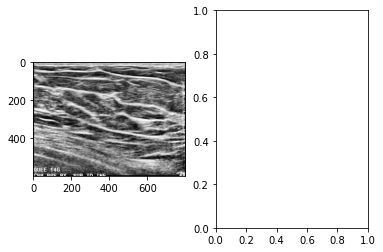

In [13]:
box_counter = 0
image_count =0
for counter, ii in enumerate(training_data.file_list):

    if (counter%200 == 0):
        print('counter at {}'.format(counter))

    box_data = training_data.bounding_boxes[counter]
    image_id = counter
    if (len(box_data) == 0): #ii[1][0]['boxes'])==0):
        continue
    else:
        img = pickle.load( open( ii, "rb" ) )
        #box_data = ii[1][0]['boxes'][0]
        #image_id = ii[1][0]['image_id']
        #print(box_data)
        #img = ii[0]
        box_counter +=1

        original_file = train_list[image_id]
        

    #img = ii[0]
    #print(np.shape(img))
    #print(ii[1][0].keys())
    box_counter +=1
    if ((box_counter % 100)==0):
        original_image = pickle.load(open(original_file,"rb"))
        plot_annotations(img, box_data, image_id, original_image)
        image_count +=1

    if (image_count > 10):
        break

In [ ]:
training_data.

#PLOT BOUNDING BOXES

In [12]:
def plot_annotations(img_data, box_data, image_id, original_image):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    #plt.figure(figsize=(8, 6), dpi=80)
    #    ax1.plot(x, y)
    #ax1.set_title('Sharing Y axis')
    #ax2.scatter(x, y)
    ax1.imshow(img_data[1,:,:], cmap='gray')
    #plt.imshow(img_data[1,:,:],cmap='gray')


    #ax = plt.gca()
    if (len(box_data) == 0):
        pass
    else:
        rect = patches.Rectangle((np.uint(box_data[0]),
                                np.uint(box_data[1] )), #np.uint(bdata[1].cpu() )),
                                np.uint(box_data[2])-(np.uint(box_data[0])),
                                np.uint(box_data[3])-(np.uint(box_data[1])),
                                linewidth=1.5,edgecolor='r',facecolor='none')

    '''
    if (len(target_boxes)==0):
        #skip this, no rectangular annotation to plot
        pass
    else:
        rect2 = patches.Rectangle((np.uint(target_boxes[0][0].cpu()),
                                np.uint(target_boxes[0][1].cpu() )),
                                np.uint(target_boxes[0][2].cpu())-(np.uint(target_boxes[0][0].cpu())),
                                np.uint(target_boxes[0][3].cpu())-(np.uint(target_boxes[0][1].cpu())),
                                linewidth=1.2,edgecolor='k',facecolor='none')
    '''


        # Add the patch to the Axes
    if (len(box_data) >0):
        ax1.add_patch(rect)
        legend_text = ['Annotation']

    plt.legend(legend_text)
    plt.colorbar()
    plt.title(str(image_id))

    figsave =0
    if(figsave == 1):
        #close this figure after writing image to drive
        save_file = os.path.join(savedir,savename)
        plt.savefig(save_file)
        plt.close()

#get adjusted bounding box

In [ ]:
def get_adjusted_bounding_box(ucla_converted_main_dir, file_name):




    #ucla_path = '/content/gdrive/My Drive/BreastUS/0TO1_NORM/UCLA_DATA_CONTRAST_EQUALIZED'
    cut_index = file_name.index(ucla_converted_main_dir) + len(ucla_converted_main_dir)+1


    short_name = file_name[cut_index:]  #removed the starting directory
    parts = short_name.split('/')
    if (dbprint == 1):
        print('file_name[] ',file_name[cut_index:])
        print(parts)
    video_part = parts[0] #get the video idea from the parsed string
    fileonly = os.path.basename(file_name) #filename without full pathing
    #converted_name = fname.replace(old_string, new_string)

    #get the original image sizes from the filename
    fnumber = re.findall(r"\d+",fileonly)
    temp_frameid = fnumber[0]  #frame id


    fnumber = re.findall(r"\d+",fileonly) #_name)
    oldr = int(fnumber[1])
    oldc = int(fnumber[2])
    skip_points =[]
    for xx in fnumber[3:]:
        skip_points.append(int(xx))
    if (dbprint == 1):
        print('oldr, oldc = ', oldr, oldc)
        print('skip points ', skip_points)
        print(bounding_boxes_data)

        



        
    ########################################################################
    # Processing to run over every type of data
    #
    ########################################################################

            #
    # Scaling values for adjusting annotation box coordinates
    # - since the images are likely upsized, the annotations need to be scaled
    # by an amount to correspond to the new image size
    #
    nr,nc = np.shape(img[0,:,:]) #this is the new resized image
    box_scalex = nc/oldc
    box_scaley = nr/oldr
    #
            #bbox = torch.FloatTensor(corners)

    # get bounding box coordinates for each mask
    num_objs = len(self.file_list) #bounding_box)
    boxes = []
    #area = 0
    pos=literal_eval(bounding_boxes_data)#[index])


    #if (len(corners)>0):
    #    width = xmax-xmin
    #    height = ymax-ymin
    #    rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
    #skip_points = [low_row, high_row,start_column, final_column]

    if (dbprint == 1):
        corners=literal_eval(bounding_boxes_data)#[index])
        print('corners ',pos)

    #pos = np.double(pos)
    if (len(pos) !=0): #(pos):

        pos = np.int32(pos)
        xmin = pos[0][0]
        xmax = pos[1][0]
        ymin = pos[0][1]
        ymax = pos[2][1]
        ### Correct for the cropped image as annotation points are for the 
        ### main image with subset
        offset_row = ymin-skip_points[0]
        offset_col = xmin-skip_points[2]
        max_row = ymax - skip_points[0]
        max_col = xmax - skip_points[2]

        #boxes.append([offset_col, offset_row, 
        #              xmax-skip_points[2], 
        #              ymax-skip_points[0]])
        x0 = offset_col * box_scalex
        y0 = offset_row * box_scaley
        x1 = max_col * box_scalex
        y1 = max_row * box_scaley

        if (dbprint ==1):
            print('----------------------------------')
            print('xo,yo,x1,y1 = ',x0,y0,x1,y1)
            print('box scale x,y ',box_scalex, box_scaley)
            print('offset col, row =',offset_col, offset_row)
            print('skip points ',skip_points)
            print('nr,nc = ', nr,nc)
            print('oldc, oldr = ', oldc, oldr)
            print('-----------------------------------')

        w = x1-x0
        h = y1-y0
        if ((w <10) or (h <10)):
            print('!!!!!! Unusable h/w found: ',h,w)
            print(x0,y0,w,h)
            print('box scale x,y ',box_scalex, box_scaley)
            print('xmin,ymin,xmax,ymax ',xmin,ymin,xmax,ymax)
            print('index is ',index)
            print('skip points ',skip_points)
            print('offset col, row =',offset_col, offset_row)
        boxes.append([x0,y0,x1,y1])
        #boxes.append([offset_col*box_scalex,
        #              offset_row*box_scaley,
        #              (xmax-skip_points[2])*box_scalex,
        #              (ymax-skip_points[0])*box_scaley])
        if (dbprint == 1):
            print('boxes= ',boxes)

        if (dbprint == 1):
            print('offsets are (col,row) ',offset_col, offset_row)
            print('skip points are ', skip_points)
            print('xmax,min,ymax,min = ', xmax,xmin, ymax,ymin)
        #boxes.append([xmin, ymin, xmax, ymax])
        #area = (xmax-skip_points[0] - offset_col) * (ymax-skip_points[2] - offset_row) 
        #adjust area to include new scaled box sizes
        area = ((xmax-skip_points[0] - offset_col)*box_scalex) * ((ymax-skip_points[2] - offset_row) * box_scaley)
        #area += (xmax-xmin)*(ymax-ymin)#!! alter this


    # Handle empty bounding boxes
    # -- UCLA data without an annotation is benign.
    # -- BUSI data without an annotation is normal, but benign cases will 
    #    have an annotation along with malignant

    #if there isn't an annotation (pos is empty)
    if (len(pos) ==0): #num_objs == 0:
        #boxes.append([0,0,0,0])
        #boxes.append([0,0,5,5]) #testing out something with an area
        #boxes = torch.zeros((1, 4), dtype=torch.double)
        #try using the whole image as negative
        nz,nr,nc = np.shape(img)
        #print('--- ',nz,nr,nc)
        boxes = torch.zeros((0, 4), dtype=torch.float32)
        #trying empty boxes instead of full size images
        #boxes.append([0.0,0.0,0.0,0.0])

        #### works: boxes.append([0.0,0.0,nc,nr])
        area = nr*nc
        boxes = torch.as_tensor(boxes, dtype=torch.double)
        #print('empty box size is ',np.shape(boxes))
        #boxes = torch.zeros((0, 4), dtype=torch.double)
        #area = 0 #10*10
        area = torch.as_tensor(area, dtype=torch.double)

        '''
        #label = torch.as_tensor(0, dtype=torch.int64) #put as background if no boxes
        if ('B' in file_label): #benign case, label should be 0
            label = torch.zeros((1,), dtype=torch.int64)
        elif ('M' in file_label): #malignant case, label should be 1
            label = torch.ones((1,), dtype=torch.int64)
        else: #something else made it through, database problem
            print('!!!LABEL ERROR!!!')
        '''


        label = torch.zeros((1,), dtype=torch.int64)

        iscrowd=torch.ones((1,), dtype=torch.int64)

    else:
        boxes = torch.as_tensor(boxes, dtype=torch.double) 
        #print('filled box size is ',np.shape(boxes))
        area = torch.as_tensor(area, dtype=torch.double)
    
        #label = torch.as_tensor(1, dtype=torch.int64)
        label = torch.ones((1,), dtype=torch.int64)
        iscrowd=torch.zeros((1,), dtype=torch.int64)


    # Use a generic label setup for UCLA, as the test directories contain
    # Malignant cases without annotations
    #if (len(pos) ==0): #Benign and normal
    #    label = torch.zeros((1,), dtype=torch.int64)
    #else:
    #    label = torch.ones((1,), dtype=torch.int64)

        ''' Use for labels
        if ('B' in file_label): #benign case, label should be 0
            label = torch.zeros((1,), dtype=torch.int64)
        elif ('M' in file_label): #malignant case, label should be 1
            label = torch.ones((1,), dtype=torch.int64)
        else: #something else made it through, database problem
            print('!!!LABEL ERROR!!!')
            stop
        '''









# GET CSV DATA FUNCTION

In [ ]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(len(rows)))
        print(row)
    return fields, rows

# GET CSV INFO

In [ ]:
#READ CSV FILES
#pull out the box information and label info
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('_final_Batch1_Batch2' in csv_file):
        annotation_fields, annotation_rows = get_csv_data(filename)
        print('Using CSV FILE: ',filename)
        break
    else:
        print('Non-archive file found ',filename)
print('Done reading CSV data')

Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated_final.csv
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated.csv
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/unzipfiles.py
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/UnzipFiles.ipynb
found rows: 18688
['18687', '1_PQ8NN45N', 'A_X4G5X404', '1_pq8nn45n_a_x4g5x404_2.mp4-2022_01_10_00_50_42-labelme 3.0.zip', '112', '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_Batch2/1_pq8nn45n_a_x4g5x404_2.mp4-2022_01_10_00_50_42-labelme 3.0.zip/default/frame_000112.png', '[]', 'Invasive ductal carcinoma, grade 2 (90% of biopsy, longest involved segment 7.5 mm). Modified Bloom and Richardson Score: 6 of 9.', 'Right Breast, 12:00, 6cm FTN', 'N/A', 'M']
Using CSV FILE:  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated_final_Batch1_Batch2.csv
Done reading CSV da

In [ ]:
annotation_rows[15590] #:15590]

count = 0
for ii in range(0,18000):
    if ('1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip' in annotation_rows[ii][3]):
        print(ii,count,annotation_rows[ii][3],annotation_rows[ii][6])
        count +=1

15957 0 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15958 1 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15959 2 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15960 3 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15961 4 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15962 5 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15963 6 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15964 7 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15965 8 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15966 9 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15967 10 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15968 11 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15969 12 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15970 13 1_4u573x42_a_

#Assign UCLA CSV DATA INTO FIELDS


*   String row is turned into a numpy array
*   Copy slices into separate lists for use in labeling/annotations



In [ ]:
#
# Pull the data from the csv array into their own field groups
#

print(np.shape(annotation_rows))

print(annotation_fields)

array_rows = np.array(annotation_rows.copy())
csv_counter = array_rows[:,0].copy() #csv line number
mrn = array_rows[:,1].copy()
accession = array_rows[:,2].copy()
video_id = array_rows[:,3].copy()
frame_id = array_rows[:,4].copy()
image_path = array_rows[:,5].copy()
bounding_box =    array_rows[:,6].copy()
diagnosis = array_rows[:,7].copy()
biopsy_site = array_rows[:,8].copy()
diagnosis2 = array_rows[:,9].copy()
first50 = array_rows[:,10].copy()


(18688, 11)
['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']


In [ ]:
ii=16050
print(annotation_rows[ii])
#print(annotation_rows[ii][6])
print(np.array(annotation_rows[ii])[6])
print(bounding_box[ii])
print(type(bounding_box[ii]))

count = 0
for ii in range(0,18000):
    if ('1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip' in video_id[ii]):
        print(ii,count,video_id[ii],bounding_box[ii])
        count +=1

['16050', '1_4U573X42', 'A_3K55O0C8', '1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip', '93', '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_Batch2/1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip/default/frame_000093.png', '[(358, 281), (445, 281), (445, 345), (358, 345)]', 'Invasive lobular carcinoma\xa0with pleomorphic features, grade\xa02. Modified Bloom and Richardson Score: 7 of 9 ', 'Left Breast, 2:00, 6 cm FTN', 'N/A', 'M']
[(358, 281), (445, 281), (445, 345), (358, 345)]
[(358, 281), (445, 281), (445, 345), (358, 345)]
<class 'numpy.str_'>
15957 0 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15958 1 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15959 2 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15960 3 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15961 4 1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip []
15962 5 1_4u573x42_a_3

In [ ]:
for ii in range(0,10):
    print(bounding_box[ii], annotation_rows[ii][6])

[] []
[] []
[] []
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)] [(274, 197), (615, 197), (615, 395), (274, 395)]


In [ ]:
for ii in range(0,18000):
    if (annotation_rows[ii][6] != np.array(annotation_rows[ii][6])):
        print(annotation_rows[ii][6], np.array(annotation_rows[ii][6]))
    #if ('1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip' in video_id[ii]):
    #    print(ii,video_id[ii],bounding_box[ii],array_rows[ii,6])

'''
for ii in range(0,18000):
    print(array_rows[ii,6])
'''

'\nfor ii in range(0,18000):\n    print(array_rows[ii,6])\n'

# PLOT ANNOTATIONS AND PREDICTED BOX

In [ ]:
def annotation_plot(img,
                    eval_label,
                    iou, 
                    score, 
                    calc_label, 
                    pred_boxes, 
                    target_boxes,
                    savedir ='',
                    savename='',
                    figsave=0):
    ############################################
    #MATPLOTLIB STUFF
    ############################################
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(img[1,:,:],cmap='gray')


    #iou_value = f'{iou:.2f}'

    '''
    if (len(eval_label) >0):
        label_value = f'{eval_label[0]:.1f}'
    else:
        label_value = 'N/A'
    '''

    
    if (score > 0):
        score_value = score#f'{score[0]['scores']:.1f}'
    else:
        score_value = 0.0 #'N/A'
    if (torch.is_tensor(iou)):
        print('found a tensor iou')
        iou = iou.numpy()
    if (calc_label ):
        plabel = calc_label
    else:
        plabel = 0 #'N/A' is the output, but it stands for background
        
    #number format for use in figure title
    iou_value = '{:04.2f}'.format(iou)
    score_value = '{:04.2f}'.format(score_value)
    
    ttext = 'iou=' + str(iou_value)+'_Plabel='+str(plabel)+'_Pscore_'+str(score_value)
    plt.title(ttext)
    #print('iou = ', iou)
    #print('------------------------------------------')

    ax = plt.gca()
    if (len(pred_boxes['boxes']) == 0):
        pass
    else:
        rect = patches.Rectangle((np.uint(pred_boxes['boxes'][0]),
                                np.uint(pred_boxes['boxes'][1] )), #np.uint(bdata[1].cpu() )),
                                np.uint(pred_boxes['boxes'][2])-(np.uint(pred_boxes['boxes'][0])),
                                np.uint(pred_boxes['boxes'][3])-(np.uint(pred_boxes['boxes'][1])),
                                linewidth=1.5,edgecolor='r',facecolor='none')

    if (len(target_boxes)==0):
        #skip this, no rectangular annotation to plot
        pass
    else:
        rect2 = patches.Rectangle((np.uint(target_boxes[0][0].cpu()),
                                np.uint(target_boxes[0][1].cpu() )),
                                np.uint(target_boxes[0][2].cpu())-(np.uint(target_boxes[0][0].cpu())),
                                np.uint(target_boxes[0][3].cpu())-(np.uint(target_boxes[0][1].cpu())),
                                linewidth=1.2,edgecolor='k',facecolor='none')


        # Add the patch to the Axes
    if (len(pred_boxes['boxes']) >0):
        ax.add_patch(rect)
    if (len(target_boxes)==0):
        legend_text = ['Prediction']
    else:
        ax.add_patch(rect2)
        legend_text = ['Prediction', 'Annotation']
    plt.legend(legend_text)
    plt.colorbar()

    if(figsave == 1):
        #close this figure after writing image to drive
        save_file = os.path.join(savedir,savename)
        plt.savefig(save_file)
        plt.close()


    return

### SAVE IMAGES TO DISK

In [ ]:
if(0):
    #['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']
    '''
    mrn = array_rows[:,1]
    accession = array_rows[:,2]
    video_id = array_rows[:,3]
    frame_id = array_rows[:,4]
    image_path = array_rows[:,5]
    bounding_box = array_rows[:,6]
    diagnosis = array_rows[:,7]
    biopsy_site = array_rows[:,8]
    diagnosis2 = array_rows[:,9]
    first50 = array_rows[:,10]
    '''

    mrn_list = set(mrn)

    acc =set()
    vid = set()

    #try first US video in first mrn


    for count,mm in enumerate(mrn):
        
        if mm in mrn[0]:
            acc.add(accession[count])
            vid.add(video_id[count])

    screen_dir = '/content/gdrive/My Drive/BreastUS/SCREEN_CAPS/'
    #video_save = os.path.join()


    file_name =[]
    vname=[]
    boundary_box = []
    for cc,video_temp in enumerate(video_id):
        [_,fpath] =image_path[cc].split('drive/MyDrive/Annotated data/')
        full_file = os.path.join(annotated_dir,fpath)
        file_name.append(full_file)
        vname.append(video_temp)
        boundary_box.append(bounding_box[cc])

    print(file_name[0])
    print(vname[0])
    print(len(file_name))


    case_holder = []
    failed_list = [] #record of images that failed cropping

    skip_to = 8002 #-1
    for count,ii in enumerate(file_name):

        if (count < skip_to):
            continue #skip these until we get back to the proper file

        #
        # Save folder information. Get the video name and make a folder with that 
        # long name in the screen caps folder
        #
        video_save = os.path.join(screen_dir,vname[count])
        if(os.path.exists(video_save)):
            print('folder found')
        else:
            os.mkdir(video_save)

        img_data = image.imread(ii)
        #print(np.shape(img_data))
        #print('Processing: ', ii)
        print(count)


        corners=literal_eval(boundary_box[count]) #bounding_box[count])
        #bounding box values are in (x,y) formats from xml
        #print('corners, len = ',corners, len(corners))
        #print('bounding box = ',boundary_box[count]) #bounding_box[count])

        '''
        Bounding box ordering is 
        point 1        point 2
        ----------------------
        point 4        point 3
        '''
        if (len(corners)>0):
            #print('corners ',pos)
            pos = np.uint(corners)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            #boxes.append([xmin, ymin, xmax, ymax])
            h=ymax-ymin
            w=xmax-xmin
        else:
            #print('EMPTY bounding box')
            xmin=np.uint(1)
            xmax=np.uint(2)
            ymin=np.uint(1)
            ymax=np.uint(2)
            h=0
            w=0
            #boxes.append([xmin, ymin, xmax, ymax])



        #skip points =[low_row, high_row,start_column, final_column]
        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B


        #
        # Crop the image to the Ultrasound borders. If it fails during this 
        # process, mark it and continue to next image. That failed index will be
        # stored to remove any failed images later
        #
        cropped_image, skip_points,fail_flag = crop_us_image(imgGray,0)


        show_plots = 0
        if (fail_flag == 1): #if cropping worked, process annotations

            #print('skip points = ',skip_points)
            #print('h = ymax-ymin',ymax,ymin,h)
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]

            if (len(corners)>0):
                width = xmax-xmin
                height = ymax-ymin
                rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
                #print('adding rectangle ',offset_row, offset_col, height, width)
                #print(ymin, ymax, xmin, xmax)
            else:
                rect = patches.Rectangle((0,0),0,0,linewidth=1,edgecolor='r',facecolor='none')

            if (show_plots == 1):
                show_crop = 0
                if (show_crop == 0):

                    fig = plt.figure(figsize=(8, 6), dpi=80)
                    #plt.figure(figsize=(8, 6), dpi=80)
                    #plt.imshow(cropped_image, cmap='gray')
                    plt.imshow(cropped_image,cmap='gray')
                    # Get the current reference
                    ax = plt.gca()
                    # Add the patch to the Axes
                    ax.add_patch(rect)

                    fname = os.path.join(video_save,os.path.basename(ii))
                    #fname = os.path.basename(ii)
                    title_text = 'Frame ' + str(fname)
                    plt.title(title_text)
                    
                    plt.savefig(os.path.join(screen_dir,str(fname)))
                    #time.sleep(1)
                    #plt.show()
                    plt.close()


                if (show_crop == 1):  
                    if (len(corners)>0):
                        plt.figure(figsize=(8, 6), dpi=80)
                        plt.imshow(img_data,cmap='gray')
                
                    # Get the current reference
                        
                        rect = patches.Rectangle((corners[0][0],corners[0][1]),w,h,linewidth=1,edgecolor='r',facecolor='none')
                        bx = plt.gca()
                        # Add the patch to the Axes
                        bx.add_patch(rect)
                        plt.show()
                        plt.close()

        else:
            print('Failed crop for : ',file_name)
            failed_list.append(count)
        #save the fail list and file name list to remove fails later
        if (count%1000 == 0):
            status_file = os.path.join(local_dir,'us_status_index2nd.pickle')

            pickle.dump([failed_list],open( status_file, "wb" ),protocol=5 )


    print('finished plotting all images')


    status_file = os.path.join(local_dir,'us_status_index2nd.pickle')
    pickle.dump([failed_list],open( status_file, "wb" ),protocol=5 )

        



    #print('filename exists: ',os.path.exists(full_file))

    #image = image.imread(full_file)
    #print(np.shape(image))


# get_bb_stats()
Used to print out information on the whole set of annotations
The XML files are in the following format:
Point1: x,y
Point2: x,y
Point3: x,y
Point4: x,y
 where the points are a box in the following shape:


 P1---------P2<br>
|--------------|<br>
|--------------|<br>
 P4---------P3
 

In [ ]:
def get_bb_stats(bounding_box):
    total_area=[]
    num_box=0
    num_h=[]
    num_w=[]

    for index in range(0,len(bounding_box)):

        #corners=literal_eval(bounding_box[index])

        boxes = []
        area = 0
        #print(type(bounding_box[index]))
        pos=literal_eval(bounding_box[index])

        #print(index,pos)
        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):
            #print('corners ',pos)
            pos = np.int32(pos)
            
            #points taken from dataloader
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]

            #xmin = pos[0][1]
            #xmax = pos[2][1]
            #ymin = pos[0][0]
            #ymax = pos[1][0]
            w=xmax-xmin
            h = ymax-ymin

            #find anything that is unreasonably small for an annotation
            if ( (h < 10) or (w < 10)):
                print('ANNOTATION TOO SMALL. h, w = ',h, w,pos)
            num_h.append(h)
            num_w.append(w)
            boxes.append([xmin, ymin, xmax, ymax])
            area += (xmax-xmin)*(ymax-ymin)
            total_area.append(area)
            num_box+=1
    return total_area, num_box,num_h, num_w

#GET COORDINATES FROM CSV

In [ ]:
def get_coordinates(video_id,video_series):
#video_series is the video_id for a series of PNG images taken from a movie.
#Anything with this id will be a frame set that should be kept together

#uvids = set(video_id)

    bbox = []
    for count,v in enumerate(video_id): #video_series:
        if (v in video_series):
            box_info = bounding_box[count]
            #box_info = box_info.strip('][') #.split(', ')

            if (not (box_info =='[]')):
                
                corners=literal_eval(box_info)
                bbox.append(torch.FloatTensor(corners))
                print(corners)
            else:
                bbox.append(torch.FloatTensor(0))

    return bbox


#                         **** Data Loaders ****





---



In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    #
    # This function handles the majority of the tensor data creation and label
    #assignments. It can handle two types of data, 0 for UCLA, and 1 for BUSI.
    #
    #
    #

    

    def __init__(self,
                 img_dir,
                 bounding_boxes,
                 label_data,
                 category=[],
                 file_count=1,
                 file_list =[],
                 data_type = 0, #0=UCLA, 1 = BUSI
                 transform=None,
                 target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.label_data = label_data
        self.bounding_boxes = bounding_boxes
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.imgs = file_list
        self.data_type = data_type


    def __getitem__(self, index):

        eps = 1e-16 #keep div by 0 away

        dbprint = 0
        image_dir = self.img_dir
        bounding_boxes_data = self.bounding_boxes[index]
        file_name = self.file_list[index]
        file_label = self.label_data[index] #for this index, the label stored
        
        #print('--------------------------------------------------')
        print(file_name)
        #print('image id ', index)

        ########################################################################
        #
        # BUSI Data loading
        #
        ########################################################################
        if (self.data_type == 2): #BUSI Images
            #all of the cropping, normalization, equalization done in 
            #the pre-processing stage. We just load in the 3d volume 
            img = pickle.load( open( file_name, "rb" ) )
            #img=cropped_image.astype(np.double)

            #get original image sizes, which are part of the 
            #filenames. An example will be:
            #  'malignant (208).png_664_617.pck'
            fnumber = re.findall(r"\d+",file_name)
            #0TO1_NORM is the first set of 2 integers in the name
            #filenum = int(fnumber[2])
            oldr = int(fnumber[3])
            oldc = int(fnumber[4])
            #get nr, nc from image filename np.shape(cropped_image) #image shape before resize
            skip_points = [0,0,0,0] #image was pre-cropped, nothing to skip
            fail_crop=0 #cropping done externally, so set to 0
        
        ########################################################################
        #
        # UCLA Data loading
        #
        ########################################################################
        elif (self.data_type == 0): #UCLA Data
            #all of the cropping, normalization, equalization done in 
            #the pre-processing stage. We just load in the 3d volume 

            if os.path.getsize(file_name) < 0:
                print('empty file --- ', file_name)
                dbprint =1
            else:
                try:
                    img = pickle.load( open( file_name, "rb" ) )
                except:
                    print('ERROR IN: ', file_name)

            #ucla_path = '/content/gdrive/My Drive/BreastUS/0TO1_NORM/UCLA_DATA_CONTRAST_EQUALIZED'
            cut_index = file_name.index(ucla_converted_main_dir) + len(ucla_converted_main_dir)+1

        
            short_name = file_name[cut_index:]  #removed the starting directory
            parts = short_name.split('/')
            if (dbprint == 1):
                print('file_name[] ',file_name[cut_index:])
                print(parts)
            video_part = parts[0] #get the video idea from the parsed string
            fileonly = os.path.basename(file_name) #filename without full pathing
            #converted_name = fname.replace(old_string, new_string)

            #get the original image sizes from the filename
            fnumber = re.findall(r"\d+",fileonly)
            temp_frameid = fnumber[0]  #frame id


            fnumber = re.findall(r"\d+",fileonly) #_name)
            oldr = int(fnumber[1])
            oldc = int(fnumber[2])
            skip_points =[]
            for xx in fnumber[3:]:
                skip_points.append(int(xx))
            if (dbprint == 1):
                print('oldr, oldc = ', oldr, oldc)
                print('skip points ', skip_points)
                print(bounding_boxes_data)
            #get nr, nc from image filename np.shape(cropped_image) #image shape before resize
            
            fail_crop=0 #cropping done externally, so set to 0
            

        else:
            stop

            
        ########################################################################
        # Processing to run over every type of data
        #
        ########################################################################

                #
        # Scaling values for adjusting annotation box coordinates
        # - since the images are likely upsized, the annotations need to be scaled
        # by an amount to correspond to the new image size
        #
        nr,nc = np.shape(img[0,:,:]) #this is the new resized image
        box_scalex = nc/oldc
        box_scaley = nr/oldr
        #
                #bbox = torch.FloatTensor(corners)

        # get bounding box coordinates for each mask
        num_objs = len(self.file_list) #bounding_box)
        boxes = []
        #area = 0
        pos=literal_eval(bounding_boxes_data)#[index])


        #if (len(corners)>0):
        #    width = xmax-xmin
        #    height = ymax-ymin
        #    rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
        #skip_points = [low_row, high_row,start_column, final_column]

        if (dbprint == 1):
            corners=literal_eval(bounding_boxes_data)#[index])
            print('corners ',pos)

        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):

            pos = np.int32(pos)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            ### Correct for the cropped image as annotation points are for the 
            ### main image with subset
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]
            max_row = ymax - skip_points[0]
            max_col = xmax - skip_points[2]

            #boxes.append([offset_col, offset_row, 
            #              xmax-skip_points[2], 
            #              ymax-skip_points[0]])
            x0 = offset_col * box_scalex
            y0 = offset_row * box_scaley
            x1 = max_col * box_scalex
            y1 = max_row * box_scaley

            if (dbprint ==1):
                print('----------------------------------')
                print('xo,yo,x1,y1 = ',x0,y0,x1,y1)
                print('box scale x,y ',box_scalex, box_scaley)
                print('offset col, row =',offset_col, offset_row)
                print('skip points ',skip_points)
                print('nr,nc = ', nr,nc)
                print('oldc, oldr = ', oldc, oldr)
                print('-----------------------------------')

            w = x1-x0
            h = y1-y0
            if ((w <10) or (h <10)):
                print('!!!!!! Unusable h/w found: ',h,w)
                print(x0,y0,w,h)
                print('box scale x,y ',box_scalex, box_scaley)
                print('xmin,ymin,xmax,ymax ',xmin,ymin,xmax,ymax)
                print('index is ',index)
                print('skip points ',skip_points)
                print('offset col, row =',offset_col, offset_row)
            boxes.append([x0,y0,x1,y1])
            #boxes.append([offset_col*box_scalex,
            #              offset_row*box_scaley,
            #              (xmax-skip_points[2])*box_scalex,
            #              (ymax-skip_points[0])*box_scaley])
            if (dbprint == 1):
                print('boxes= ',boxes)

            if (dbprint == 1):
                print('offsets are (col,row) ',offset_col, offset_row)
                print('skip points are ', skip_points)
                print('xmax,min,ymax,min = ', xmax,xmin, ymax,ymin)
            #boxes.append([xmin, ymin, xmax, ymax])
            #area = (xmax-skip_points[0] - offset_col) * (ymax-skip_points[2] - offset_row) 
            #adjust area to include new scaled box sizes
            area = ((xmax-skip_points[0] - offset_col)*box_scalex) * ((ymax-skip_points[2] - offset_row) * box_scaley)
            #area += (xmax-xmin)*(ymax-ymin)#!! alter this


        # Handle empty bounding boxes
        # -- UCLA data without an annotation is benign.
        # -- BUSI data without an annotation is normal, but benign cases will 
        #    have an annotation along with malignant

        #if there isn't an annotation (pos is empty)
        if (len(pos) ==0): #num_objs == 0:
            #boxes.append([0,0,0,0])
            #boxes.append([0,0,5,5]) #testing out something with an area
            #boxes = torch.zeros((1, 4), dtype=torch.double)
            #try using the whole image as negative
            nz,nr,nc = np.shape(img)
            #print('--- ',nz,nr,nc)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            #trying empty boxes instead of full size images
            #boxes.append([0.0,0.0,0.0,0.0])

            #### works: boxes.append([0.0,0.0,nc,nr])
            area = nr*nc
            boxes = torch.as_tensor(boxes, dtype=torch.double)
            #print('empty box size is ',np.shape(boxes))
            #boxes = torch.zeros((0, 4), dtype=torch.double)
            #area = 0 #10*10
            area = torch.as_tensor(area, dtype=torch.double)

            '''
            #label = torch.as_tensor(0, dtype=torch.int64) #put as background if no boxes
            if ('B' in file_label): #benign case, label should be 0
                label = torch.zeros((1,), dtype=torch.int64)
            elif ('M' in file_label): #malignant case, label should be 1
                label = torch.ones((1,), dtype=torch.int64)
            else: #something else made it through, database problem
                print('!!!LABEL ERROR!!!')
            '''


            label = torch.zeros((1,), dtype=torch.int64)

            iscrowd=torch.ones((1,), dtype=torch.int64)

        else:
            boxes = torch.as_tensor(boxes, dtype=torch.double) 
            #print('filled box size is ',np.shape(boxes))
            area = torch.as_tensor(area, dtype=torch.double)
        
            #label = torch.as_tensor(1, dtype=torch.int64)
            label = torch.ones((1,), dtype=torch.int64)
            iscrowd=torch.zeros((1,), dtype=torch.int64)


        # Use a generic label setup for UCLA, as the test directories contain
        # Malignant cases without annotations
        #if (len(pos) ==0): #Benign and normal
        #    label = torch.zeros((1,), dtype=torch.int64)
        #else:
        #    label = torch.ones((1,), dtype=torch.int64)

            ''' Use for labels
            if ('B' in file_label): #benign case, label should be 0
                label = torch.zeros((1,), dtype=torch.int64)
            elif ('M' in file_label): #malignant case, label should be 1
                label = torch.ones((1,), dtype=torch.int64)
            else: #something else made it through, database problem
                print('!!!LABEL ERROR!!!')
                stop
            '''

        #
        # Protect against zero images from earlier in this function.
        #
        if (fail_crop == 1):
            #force this image to be a background image for training
            print('forcing image as background for failed image')
            label = torch.zeros((1,), dtype=torch.int64)
            iscrowd=torch.ones((1,), dtype=torch.int64)

        if (dbprint == 1):
            print('shape of boxes is ', np.shape(boxes))


        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        ###iscrowd = torch.zeros((len(self.imgs),), dtype=torch.double)

        if (dbprint == 1):
            print('setting target')
            print('label is ', label, type(label))
            print('area is ', area)
        


        target = []
        d = {}
        d['boxes'] = boxes  #np.squeeze(boxes,0)
        d['labels'] = label
        d['image_id'] = torch.as_tensor(index, dtype=torch.double) 
        d['area'] = area 
        d['iscrowd'] = iscrowd 
        target.append(d)

        #self.transform(self.x_data[index]), self.transform(self.y_data[index])
        #return {'image': torch.from_numpy(image),
#                'landmarks': torch.from_numpy(landmarks)}
        #return self.transform(img), self.transform(target)
        
        #print('image type before is ', type(img))
        img = torch.as_tensor(img, dtype=torch.float32) #model has float32 
        #img= torch.from_numpy(img)
        #print('image type after is ', type(img))
        #img = torchvision.transforms.ToTensor()(image)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def collate_fn(batch):  #borrowed
    return tuple(zip(*batch))

#GENERATE ALL FILE PATHS AND TRIMMED CSV DATA

In [ ]:
#
# Assign CSV data to each of the pre-generated files. Since some raw files may 
# not pass the cropping stage, the 1:1 correspondence between # images and CSV
# rows was broken.
#

if (training_set ==0):

    print('Setting up UCLA Ultrasound Training Data')

    #New lists to hold the trimmed CSV data
    full_file_list=[]
    mrn_final = []
    accession_final = []
    frame_id_final = []
    diagnosis_final = []
    bb_final=[]
    label_first50=[]
    video_id_final =[]
    accession_final = []
    image_path_final = []
    skip_points_final=[]

    '''
    array_rows = np.array(annotation_rows)
    mrn = array_rows[:,1]
    accession = array_rows[:,2]
    video_id = array_rows[:,3]
    frame_id = array_rows[:,4]
    image_path = array_rows[:,5]
    bounding_box = array_rows[:,6]
    diagnosis = array_rows[:,7]
    biopsy_site = array_rows[:,8]
    diagnosis2 = array_rows[:,9]
    first50 = array_rows[:,10]
    '''

    #
    # The pickle list contains full file locations for files in the pre-processed
    # folder. Any raw data that was corrupt or couldn't be cropped is not 
    # included in this list.
    # One problem with this shortened file list is that our csv rows do not 
    # align with the files anymore. Re-align them.
    #
    video_last =''
    for file_counter,fname in enumerate(ucla_pickle_list):
        #print('------------',fname)
        #if ('1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip' in fname):
        #    pass
        #else:
        #    continue

        match_found = 0  #toggle when a bounding box is assigned

        ########################################################################
        # Get the video info from the filename. Use this to match up to the
        # raw CSV info from the annotation files
        ########################################################################
        #index = fname.find(ucla_converted_main_dir)
        index = fname.index(ucla_converted_main_dir) + len(ucla_converted_main_dir)+1


        #print('index = ', index)
        short_name = fname[index:]  #removed the starting directory
        parts = short_name.split('/')
        #print(fname[index:])
        #print(parts)
        video_part = parts[0] #get the video idfrom the parsed string
        fileonly = os.path.basename(fname) #filename without full pathing
        #converted_name = fname.replace(old_string, new_string)

        #get the original image sizes from the filename
        fnumber = re.findall(r"\d+",fileonly)
        temp_frameid = fnumber[0]  #frame id
        original_row = fnumber[1]
        original_col = fnumber[2]
        skip_points = fnumber[3:]

        if (len(video_part) < 20):
            print('Name is not long enough.')
            stop

        if (video_part == video_last):
            pass
        else:
            #first time seeing this video, set it to default and reset frame counter
            #print('setting default vid name ',video_part)
            video_last = video_part
            frames_found_already =[]

        #scan through the video id list to get a match, then drill down to 
        #the frame number. There's probably a more python way to do this...
        for vcount,vid in enumerate(video_id):

            #frames_found_already =[] #keep a record of frames processed for vid
            #print('---vcount ', vcount, video_part, vid)
            if (video_part == vid):

                #match, so now check the frame
                #print('video matches', vcount, video_part, frame_id[vcount])
                for fcount, frame in enumerate(frame_id[vcount:]):
                    row_index = fcount + vcount #vcount is video row then frame

                    if ((int(temp_frameid) == int(frame)) and  
                        (int(temp_frameid) not in frames_found_already[:])
                        ):
                        print('frame is ', vcount,fcount,temp_frameid,frame,
                              bounding_box[row_index], vid, file_counter)
                        frames_found_already.append(int(frame))
                        match_found =1
                        break

                if (match_found == 1):
                    break
            else:
                continue
            if (match_found == 1):
                break

        if (match_found == 1):
            #
            # Assign the row data to our final table
            #
            full_file_list.append(fname)
            mrn_final.append(mrn[row_index])
            frame_id_final.append(frame_id[row_index])
            diagnosis_final.append(diagnosis[row_index])

            bb_final.append(bounding_box[row_index])
            label_first50.append(first50[row_index])
            video_id_final.append(video_id[row_index])
            accession_final.append(accession[row_index])
            image_path_final.append(fname) #image_path[vcount])
            skip_points_final.append(skip_points)


        else:
            #no match found, error
            print('failed vcount = ',vcount)
            stop
    
    print('# files ',len(full_file_list))

 


################################################################################
#
# BUSI and mixed UCLA/BUSI set
#
################################################################################
if (training_set ==2):
    print('Setting up BUSI data set')
    if (training_set == 2): # we need initial list setups, since UCLA data was
    # not processed
        full_file_list = []
        bounding_box = []
        first50=[]
    else:
        print('Using lists defined in UCLA Dataset')
        bounding_box = list(bounding_box)
        first50 = list(first50)

    for category in busi_dirs:
        if ('malignant' in category):
            for key_val in image_m_dict.keys():
                full_file_list.append(image_m_dict[key_val])
                bounding_box.append(np.str(mask_m_dict[key_val]))
                first50.append(np.str('M'))

            print('done with adding malignant files')
        elif ('normal' in category):
            for key_val in image_n_dict.keys():
                full_file_list.append(image_n_dict[key_val])
                bounding_box.append(np.str(mask_n_dict[key_val]))
                first50.append(np.str('B'))

            print('done with adding normal files')
        else:
            for key_val in image_b_dict.keys():
                full_file_list.append(image_b_dict[key_val])
                bounding_box.append(np.str(mask_b_dict[key_val]))
                first50.append(np.str('B'))

            print('done with adding benign files')
    original_file_length = len(full_file_list)

Streaming output truncated to the last 5000 lines.
frame is  13609 80 000080 80 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13273
frame is  13609 81 000081 81 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13274
frame is  13609 82 000082 82 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13275
frame is  13609 83 000083 83 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13276
frame is  13609 84 000084 84 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13277
frame is  13609 85 000085 85 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13278
frame is  13609 86 000086 86 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13279
frame is  13609 87 000087 87 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13280
frame is  13609 88 000088 88 [] 1_d8g4kjw4_a_t56q311s_2.mp4-2022_01_30_21_30_52-labelme 3.0.zip 13281
frame is  13609 89 000089 89 []

In [ ]:
for ii in range(0,7):
    print(video_id[ii], bounding_box[ii])
    print(video_id_final[ii],bb_final[ii])

1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip []
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip [(274, 197), (615, 197), (615, 395), (274, 395)]
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip []
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip []
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip []
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip []
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip [(274, 197), (615, 197), (615, 395), (274, 395)]
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip []
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip [(274, 197), (615, 197), (615, 395), (274, 395)]
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip [(274, 197), (615, 197), (615, 395), (274, 395)]
1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip [(274, 197), (615, 197), (615, 395), (274, 395)]
1_076up782_a_dcc4675o_0.mp4-2021_

In [ ]:
print(len(ucla_pickle_list))
print(len(full_file_list))
print(len(bb_final))
print(parts[0])
print(int(temp_frameid))
print(len(set(image_path_final)))

temp_csv= os.path.join(local_dir,'out.csv')
with open(temp_csv, 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    for rcount in range(0,len(bb_final)):

        # write a row to the csv file
        rowdata = [rcount,video_id[rcount], bounding_box[rcount]]
        writer.writerow(rowdata)


    '''
    array_rows = np.array(annotation_rows)
    mrn = array_rows[:,1]
    accession = array_rows[:,2]
    video_id = array_rows[:,3]
    frame_id = array_rows[:,4]
    image_path = array_rows[:,5]
    bounding_box = array_rows[:,6]
    diagnosis = array_rows[:,7]
    biopsy_site = array_rows[:,8]
    diagnosis2 = array_rows[:,9]
    first50 = array_rows[:,10]
    '''
'''
for count,ii in enumerate(bb_final):
    if (ii ==  '[]'):
        print(count, 'empty')
    else:
        print(count,'------bb')
'''

18272
18272
18272
1_pq8nn45n_a_x4g5x404_2.mp4-2022_01_10_00_50_42-labelme 3.0.zip
112
18272


"\nfor count,ii in enumerate(bb_final):\n    if (ii ==  '[]'):\n        print(count, 'empty')\n    else:\n        print(count,'------bb')\n"

# Bounding Box information

In [ ]:
if (0):
    #------not needed??
    # Bounding box info
    #

    import torch
    print('-------')
    uvids = set(video_id)

    for v in uvids:
        for count,ii in enumerate(video_id):
            if (v in ii):
                #get bb info
                box_info = bounding_box[count]
                #box_info = box_info.strip('][') #.split(', ')

                if (not (box_info =='[]')):
                    
                    corners=literal_eval(box_info)
                    bbox = torch.FloatTensor(corners)
                    #print(corners)
                else:
                    continue
    '''
    print(full_file_list[0])
    if (use_busi == 1):
        print('Adding BUSI bounding boxes')
        for filename in full_file_list:
            if ('BUSI_DATA' in filename):
                print(filename)
                #found one of our busi sets, check what category
                #TODO  replace if set with scanf utility to get category
                if ('malignant' in filename):
                    print(filename)
                    first50.append('M')
                    bounding_box.append(mask_m_dict[])
                    break
    '''


#BOUNDING BOX STATISTICS **** ADJUST FOR BUSI

In [ ]:
if (training_set ==0):
    ############################################################################
    #
    # UCLA DATA
    ############################################################################
    
    #
    # Reassign the updated set of csv data to the old names. This lets us resuse
    # some of the pre-existing functions and code
    #

    #full_file_list.append(fname)
    #bb_final.append(bounding_box[vcount])
    #label_first50.append(first50[vcount])
    #video_id_final.append(video_id[vcount])
    #accession_final.append(accession[vcount])
    #image_path_final.append(image_path[vcount])
    #skip_points_final.append(skip_points)


    bbox = []
    first50 = []
    video_id = []
    image_path = []
    accession = []

    bbox = bb_final.copy()
    first50=label_first50.copy()
    video_id = video_id_final.copy()
    image_path = image_path_final.copy()
    accession = accession_final.copy()


    #generate stats on bounding boxes

    #get a list of all the unique video ids to remove the extra rows
    uvids = set(video_id)

    #
    # Store metrics on bounding box information present
    #
    box_collect=[]
    frames_collect=[]
    empty_annotations=[]

    for count, v in enumerate(uvids):
        #go through each unique video name and do a search to find every 
        #match with that unique id
        number_frames = 0
        number_boxes = 0
        
        #print('---- loading: ', v)
        for icount,ivideo in enumerate(video_id):
            if (ivideo == v): #if the unique vid matches this video id

                #print(icount,v,bounding_box[icount])
                #print(csv_counter[icount],v,bounding_box[icount])
                box_info = bb_final[icount] #bounding_box[icount]
                number_frames+=1

                #if ('1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip' in ivideo):
                #if ('1_4u573x42_a_3k55o0c8_1.mp4-2022_02_04_22_29_00-labelme 3.0.zip' in ivideo):
                #    print('{} {} {} {} {} {}'.format(icount, bb_final[icount],box_info,number_frames,image_path[icount],ivideo))
                if ((box_info =='[]')):
                    pass
                else:
                    number_boxes = number_boxes +1
                    #print('no annotation', frame_id[icount])
        #collect metrics on findings
        frames_collect.append(number_frames)
        box_collect.append(number_boxes)
        #print(v,number_frames,number_boxes)
        if (number_boxes == 0):
            empty_annotations.append(v)
            #print('EMPTY:   ',v)
            


    print('Number of videos: ',np.size(frames_collect[:]))
    print('Number of annotated cases ',np.size(box_collect))
    print('Number of unannotated cases ', np.size(empty_annotations))
    print('Videos with no Annotations:', np.size(empty_annotations))
    print(box_collect)
        #get_bb_stats(v, video_id,bounding_box, image_path)

    print('------- NO ANNOTATION VIDEOS --------')
    for ii in empty_annotations:
        print('empty: ', ii)


else:
    print('Skipping Bounding box statistics for UCLA data')


Number of videos:  203
Number of annotated cases  203
Number of unannotated cases  39
Videos with no Annotations: 39
[51, 71, 37, 19, 42, 48, 0, 125, 0, 45, 0, 34, 76, 47, 81, 54, 31, 104, 25, 15, 0, 51, 25, 59, 36, 55, 45, 65, 0, 29, 25, 75, 42, 56, 0, 52, 16, 103, 0, 53, 0, 31, 59, 0, 60, 0, 95, 50, 45, 37, 49, 25, 0, 56, 16, 54, 60, 0, 47, 41, 53, 26, 58, 0, 29, 0, 65, 102, 103, 67, 0, 0, 0, 23, 35, 87, 44, 43, 21, 50, 41, 44, 56, 0, 42, 58, 76, 17, 32, 49, 67, 25, 62, 25, 57, 0, 36, 0, 23, 0, 0, 81, 87, 41, 24, 59, 78, 0, 0, 53, 0, 18, 0, 38, 37, 18, 32, 29, 37, 67, 181, 74, 88, 36, 57, 92, 171, 0, 45, 50, 53, 59, 72, 47, 80, 0, 115, 0, 48, 88, 41, 36, 30, 0, 41, 42, 48, 0, 284, 38, 29, 0, 25, 43, 87, 150, 190, 29, 100, 81, 83, 0, 113, 0, 0, 55, 28, 28, 23, 64, 63, 77, 68, 85, 0, 40, 50, 62, 51, 84, 55, 74, 97, 38, 82, 34, 83, 43, 29, 51, 83, 69, 0, 60, 39, 0, 47, 70, 0, 41, 58, 31, 71]
------- NO ANNOTATION VIDEOS --------
empty:  1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-la

In [ ]:
ucla_pickle_list[0:3]
print(len(set(video_id_final)))


203


#ANNOTATION HISTOGRAM INFO

average area =  42797.94495802784
average width =  231.95335245988736
smallest width is  41
largest width is   574
149.802146424397
smallest height is  32
largest height is   359
----- [ 14.  73.  50. 206. 155. 328. 230. 285. 683. 404. 232. 440. 353. 307.
 444. 309. 537. 465. 723. 514. 258. 159.  51. 123. 181. 116.   9. 371.
 167. 101.   5. 114. 149.   2.   7.   0.   0.   0.   0.   0. 125.  56.
 165.  85.  76.  83.   0. 104.  74.  78.]
max Height bin is  0 683.0
max Height bin is  1 723.0
max Height bin is  2 371.0
max Height bin is  3 149.0
max Height bin is  4 165.0
----- [160.  46.  23. 100. 248. 228. 401. 562. 474. 507. 587. 548. 363. 285.
 492. 358. 216. 287. 294. 183.  69. 237. 215. 177. 147. 295. 100.  24.
 110.   2.   2.  87. 155. 245.   9. 164.  56.  82.   0.  50. 125.  85.
 104.   0. 178.   0.  56. 161.  40.  74.]
max Width bin is  0 562.0
max Width bin is  1 587.0
max Width bin is  2 295.0
max Width bin is  3 245.0
max Width bin is  4 178.0


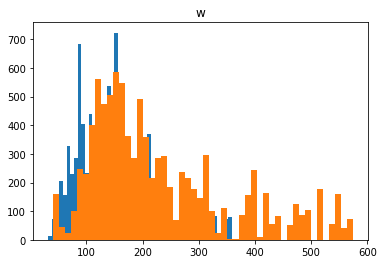

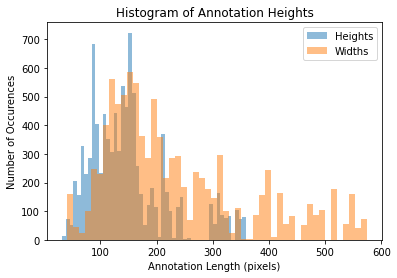

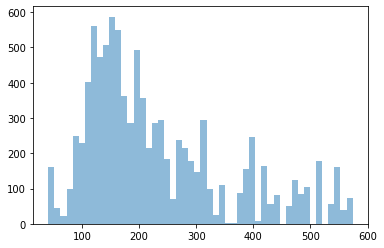

In [ ]:
if (training_set ==0):

    #bounding_box
    ta,box_num,num_h, num_w=get_bb_stats(bb_final) #bounding_box)

    avg_area = sum(ta)/len(ta)
    print('average area = ',avg_area)

    #avg width
    print('average width = ',np.average(num_w))
    #get smallest box

    print('smallest width is ', np.min(num_w))
    print('largest width is  ', np.max(num_w))

    #avg height
    print(np.average(num_h))
    print('smallest height is ', np.min(num_h))
    print('largest height is  ',np.max(num_h))

    vv,_,_=plt.hist(num_h, bins = 50)
    plt.title('h')
    print('-----',vv)

    for ii in range(0,5):
        bin_max = np.max(vv[ii*10:ii*10+9])
        print('max Height bin is ', ii,bin_max)

    vv,_,_=plt.hist(num_w, bins = 50)
    plt.title('w')
    print('-----',vv)

    for ii in range(0,5):
        bin_max = np.max(vv[ii*10:ii*10+9])
        print('max Width bin is ', ii,bin_max)




    plt.figure()
    plt.hist(num_h, bins=50,alpha=0.5, label="Heights")
    plt.hist(num_w,bins=50,alpha=0.5, label="Widths")
    plt.title('Histogram of Annotation Heights')
    plt.ylabel('Number of Occurences')
    plt.xlabel('Annotation Length (pixels)')
    plt.legend(loc='upper right')

    plt.figure()
    plt.hist(num_w,bins=50,alpha=0.5, label="Widths")


In [ ]:
print(len(set(accession_final)))

umrn = set(mrn_final)

mrn_dict ={}
for ii in umrn:
    mrn_dict[ii]=[]
    for jcounter,jj in enumerate(mrn_final):
        if (ii == jj):
            mrn_dict[ii].append(jcounter)
            #print('{} {}'.format(ii,jj))


total=0
mrn_groups ={} 
for kk in mrn_dict.keys():
    number_items = len(mrn_dict[kk])
    acc_list =[]
    for jj in mrn_dict[kk]:
        acc_list.append(accession_final[jj])
    print('---------------------')
    print('{}'.format(set(acc_list)))
    mrn_groups[kk] =acc_list

    total+=number_items
    #print('{} {}'.format(kk,number_items))


print('*************************************************')
print('Total Patients/MRN: ',len(umrn))
print('Total values ',total)
print('Total Patients/groups: ', len(mrn_groups.keys()))

88
---------------------
{'A_9T266V59'}
---------------------
{'A_75R66V4X'}
---------------------
{'A_5LE6405L'}
---------------------
{'A_3ZBM0G76'}
---------------------
{'A_P1T1KL5G'}
---------------------
{'A_W7940294'}
---------------------
{'A_32N0Q57D'}
---------------------
{'A_U4C2047O'}
---------------------
{'A_HMKN4BHH'}
---------------------
{'A_531R5JN5'}
---------------------
{'A_9NO52R58'}
---------------------
{'A_1CLH6OGF'}
---------------------
{'A_N4P8955P'}
---------------------
{'A_H2VRV14E'}
---------------------
{'A_0W9J3G5T'}
---------------------
{'A_1TZU23A4'}
---------------------
{'A_291NE599'}
---------------------
{'A_DCC4675O'}
---------------------
{'A_EFP76J40'}
---------------------
{'A_0629S3FH'}
---------------------
{'A_EI03GM12'}
---------------------
{'A_165J9J5D'}
---------------------
{'A_6A8210BH'}
---------------------
{'A_87UFD6LP'}
---------------------
{'A_7688MV84', 'A_4XW9S70R'}
---------------------
{'A_F4QKVI8R', 'A_QN0P5AX9'}
-------

In [ ]:



print(type(umrn))
print(len(umrn))
print(len(list(umrn)))
number_vids = len(umrn)
train = 0.6 #60% of full umrn data
validation = 0.5 #50% of the remaining data after training data partitioned
test = 0.5

#Get a set % of the unique mrn values for the training set
train_vids = random.sample(list(set(umrn)), k=int(train*number_vids))

print('Training set length is ',len(train_vids), len(set(train_vids)) )

#
# Generate validation and test test cases and make sure none of them are 
# shared by the training set
#
valtest = [] #store leftover videos not used for training
ucounter=0 #number of unique values not found in training set
miss = 0
#cycle through each unique mrn value and then check if it is in the 
#training partition created earlier

print('length of sets: umrn {}   train_vids {}'.format(len(umrn),
                                                       len(set(train_vids))))
valtest = set(umrn) - set(train_vids)
print('length of valtest group is {}'.format(len(valtest)))

#
# Select Validation and Test from Remaining unique mrn cases
#
val_vids = random.sample(list(set(valtest)), k=int(validation*len(valtest)))
test_vids = set(valtest) - set(val_vids)

print('Validation Size {}  Test Size {}'.format(len(val_vids), len(test_vids)))


for ii in valtest:
    for jj in train_vids:
        if (ii == jj):
            print('found a same video ',  ii,jj) #list(umrn)[jj])
            break


<class 'set'>
80
80
Training set length is  48 48
length of sets: umrn 80   train_vids 48
length of valtest group is 32
Validation Size 16  Test Size 16


#SPLIT INPUT DATA INTO TRAIN/VAL/TEST FOLDERS
UCLA data has patient sets that may or may not contain multiple cines from a single patient. Not only do you need to keep the full cine together in its category (train/val/test), but you need to keep that patient set together too, else you end up with the next series from that patient being used in validation or test

BUSI data is all individual images (as far as I can tell), so mixing is not an issue.

#train_val_dataset   

used to do a training split for the single image BUSI data

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))),
                                          test_size=val_split)
    #datasets = {}
    #datasets['train'] = Subset(dataset, train_idx)
    #datasets['val'] = Subset(dataset, val_idx)
    return train_idx, val_idx #datasets

#Split BUSI Data into Train/Val sets

In [ ]:
#Split the BUSI data files, as they're not related sets
if (training_set == 1): #mixed -- no longer used

    t,v = train_val_dataset(full_file_list[8842:], val_split=0.2)
    for counter, ii in enumerate(t):
        t[counter] = ii+original_file_length
    for counter, ii in enumerate(v):
        v[counter] = ii + original_file_length

    print(len(full_file_list))
    print(np.max(t), np.max(v))
    for ii in t:
        print(full_file_list[ii])
    
    stop
elif(training_set == 2):
    print('Splitting ONLY BUSI data')
    t,v = train_val_dataset(full_file_list, val_split=0.2)

    print(len(full_file_list), len(t), len(v))
    print(np.max(t), np.max(v))
    for ii in t:
        print(full_file_list[ii])
else:
    print('Non-BUSI being used.')



Non-BUSI being used.


#Assign Training/Validation/Test files

In [ ]:
if (training_set ==0):
    #
    # UCLA DATA SET -- includes batch1 series and batch2
    # These files are the pared down total set that has removed any images that
    #  did not pass the cropping phase. 


    train_list = []
    val_list = []
    test_list = []
    train_labels=[]
    val_labels =[]
    test_labels = []
    train_box =[]
    val_box=[]
    test_box = []

    '''
    train_skip =[]
    val_skip =[]
    test_skip =[]
    '''
    '''
            full_file_list.append(fname)
            mrn_final.append(mrn[row_index])
            frame_id_final.append(frame_id[row_index])
            diagnosis_final.append(diagnosis[row_index])

            bb_final.append(bounding_box[row_index])
            label_first50.append(first50[row_index])
            video_id_final.append(video_id[row_index])
            accession_final.append(accession[row_index])
            image_path_final.append(fname) #image_path[vcount])
            skip_points_final.append(skip_points)
    '''

    #
    # Go through every unique mrn name and assign all of the filenames under that
    # to the training set
    #
    for uname in train_vids:
        for counter,filename in enumerate(full_file_list):
            #print('{} {}'.format(uname, filename))
            if (uname.lower() in filename): 
                #keep this file for this set
                train_list.append(filename)
                train_labels.append(label_first50[counter])
                train_box.append(bb_final[counter])
                #train_skip.append(skip_points_final[counter])
                #break
    print('# of Training files found {}'.format(len(train_list)))


    #
    # VALIDATION ASSIGNMENT
    #

    for uname in val_vids:
        for counter,filename in enumerate(full_file_list):
            #print('{} {}'.format(uname, filename))
            if (uname.lower() in filename): 
                #keep this file for this set
                val_list.append(filename)
                val_labels.append(label_first50[counter])
                val_box.append(bb_final[counter])
                #train_skip.append(skip_points_final[counter])
                #break
    print('# of Validation files found {}'.format(len(val_list)))

    #
    # TEST ASSIGNMENT
    #

    for uname in test_vids:
        for counter,filename in enumerate(full_file_list):
            #print('{} {}'.format(uname, filename))
            if (uname.lower() in filename): 
                #keep this file for this set
                test_list.append(filename)
                test_labels.append(label_first50[counter])
                test_box.append(bb_final[counter])
                #train_skip.append(skip_points_final[counter])
                #break
    print('# Test files found {}'.format(len(test_list)))



elif (training_set == 2):
    #Add BUSI data to the end of the lists
    train_list = []
    val_list = []
    test_list = []
    train_labels=[]
    val_labels =[]
    test_labels = []
    train_box =[]
    val_box=[]
    test_box = []
    for counter, ii in enumerate(t):
        train_list.append(full_file_list[ii])
        train_labels.append(first50[ii])
        train_box.append(bounding_box[ii])
    for counter, ii in enumerate(v):
        val_list.append(full_file_list[ii])
        val_labels.append(first50[ii])
        val_box.append(bounding_box[ii])

else:
    print('Mixed Data (UCLA + BUSI) no longer allowed')
    '''
    train_list = []
    val_list = []
    train_labels=[]
    val_labels =[]
    train_box =[]
    val_box=[]


    for counter,dir_name in enumerate(train_vidid):
        print(dir_name)
        for ii in os.path.join()
        train_list.append(fname)
    '''

#print the files used for later stages and their labes and boxes
data_file = os.path.join(model_dir,'train_val_test_data.pickle')
pickle.dump([train_list,
            train_labels,
            train_box,
            val_list,
            val_labels,
            val_box, 
            test_list,
            test_labels,
            test_box,],open( data_file, "wb" ),protocol=5 )
print('Finished writing file data to disk')

print('--- ',len(train_list), len(val_list), len(test_list)) #,num_train, num_val,num_test)


# of Training files found 10896
# of Validation files found 3771
# Test files found 3605
Finished writing file data to disk
---  10896 3771 3605


#DEBUG: CROP AND ANNOTATE

/content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_6236c187_a_qn0p5ax9_1.mp4-2021_09_03_18_14_24-labelme 3.0.zip/default/frame_000019.PNG_600_800_103_567_190_657.pck
---  48
file_name[]  1_6236c187_a_qn0p5ax9_1.mp4-2021_09_03_18_14_24-labelme 3.0.zip/default/frame_000019.PNG_600_800_103_567_190_657.pck
['1_6236c187_a_qn0p5ax9_1.mp4-2021_09_03_18_14_24-labelme 3.0.zip', 'default', 'frame_000019.PNG_600_800_103_567_190_657.pck']
oldr, oldc =  600 800
skip points  [103, 567, 190, 657]
[(234, 125), (636, 125), (636, 446), (234, 446)]
pos length =  4
bounding box = (xmin,ymin,xmax,ymax)  234 125 636 446
scalex,y =  1.0 1.0
[44.0, 22.0, 446.0, 343.0]


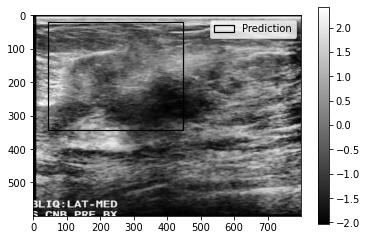

In [ ]:

#MISSING SKIP COORDINATES, SO ANNOTATIONS ARE NOT CORRECT
if(1):
    dbprint = 1 #turn on debug statements
    boxes=[]
  
    ii= 400 #8500
    print(train_list[ii])
    img = pickle.load( open( train_list[ii], "rb" ) )
    #img = image.imread(train_list[ii])
    print('--- ', len(train_box[ii]))
    pos=literal_eval(train_box[ii])



    file_name = train_list[ii]

    #ucla_path = '/content/gdrive/My Drive/BreastUS/0TO1_NORM/UCLA_DATA_CONTRAST_EQUALIZED'
    cut_index = file_name.index(ucla_converted_main_dir) + len(ucla_converted_main_dir)+1


    short_name = file_name[cut_index:]  #removed the starting directory
    parts = short_name.split('/')
    if (dbprint == 1):
        print('file_name[] ',file_name[cut_index:])
        print(parts)
    video_part = parts[0] #get the video idea from the parsed string
    fileonly = os.path.basename(file_name) #filename without full pathing
    #converted_name = fname.replace(old_string, new_string)

    #get the original image sizes from the filename
    fnumber = re.findall(r"\d+",fileonly)
    temp_frameid = fnumber[0]  #frame id


    fnumber = re.findall(r"\d+",fileonly) #_name)
    oldr = int(fnumber[1])
    oldc = int(fnumber[2])
    skip_points =[]
    for xx in fnumber[3:]:
        skip_points.append(int(xx))
    if (dbprint == 1):
        print('oldr, oldc = ', oldr, oldc)
        print('skip points ', skip_points)
        print(train_box[ii])

    bounding_boxes_data = train_box[ii]
    

    pos=literal_eval(bounding_boxes_data)#[index])
    print('pos length = ',len(pos))
    
    
 
    if (len(pos) <1 ):
        print('no annotation to view')
    else:
        pos = np.int32(pos)
        xmin = pos[0][0]
        xmax = pos[1][0]
        ymin = pos[0][1]
        ymax = pos[2][1]

        print('bounding box = (xmin,ymin,xmax,ymax) ', xmin, ymin, xmax,ymax)

        ### Correct for the cropped image as annotation points are for the 
        ### main image with subset


        offset_row = ymin-skip_points[0]
        offset_col = xmin-skip_points[2]
        max_row = ymax - skip_points[0]
        max_col = xmax - skip_points[2]

        #boxes.append([offset_col, offset_row, 
        #              xmax-skip_points[2], 
        #              ymax-skip_points[0]])

        nr,nc = np.shape(img[0,:,:]) #this is the new resized image

        box_scalex = nc/oldc
        box_scaley = nr/oldr
        x0 = offset_col * box_scalex
        y0 = offset_row * box_scaley
        x1 = max_col * box_scalex
        y1 = max_row * box_scaley

        print('scalex,y = ', box_scalex, box_scaley)
        w = x1-x0
        h = y1-y0
        if ((w <10) or (h <10)):
            print('!!!!!! Unusable h/w found: ',h,w)
            print(x0,y0,w,h)
            print('box scale x,y ',box_scalex, box_scaley)
            print('xmin,ymin,xmax,ymax ',xmin,ymin,xmax,ymax)
            print('index is ',index)
            print('skip points ',skip_points)
            print('offset col, row =',offset_col, offset_row)
        boxes.append([x0,y0,x1,y1])







        target_boxes = [x0,y0,x1,y1] #pos #train_box[ii]
        plt.figure()
        plt.imshow(img[1,:,:],cmap='gray')


        print(target_boxes)
        ax = plt.gca()
        rect2 = patches.Rectangle((np.uint(x0),
                                np.uint(y0)),
                                np.uint(x1)-(np.uint(x0)),
                                np.uint(y1)-(np.uint(y0)),
                                linewidth=1.2,edgecolor='k',facecolor='none')


            # Add the patch to the Axes

        if (len(target_boxes)==0):
            legend_text = ['Prediction']
        else:
            ax.add_patch(rect2)
            legend_text = ['Prediction', 'Annotation']
        plt.legend(legend_text)
        plt.colorbar()


/content/gdrive/Shareddrives/BreastUS/Annotated data
/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated_plus_Batch2/1_g0ht1c3t_a_h446gjgf_1.mp4-2021_09_03_18_24_27-labelme 3.0.zip/default/frame_000077.PNG
True


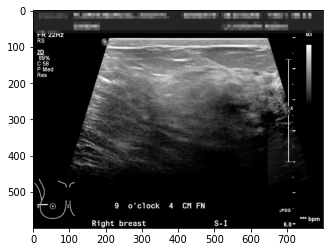

In [ ]:

from PIL import Image
import imageio

#im = imageio.imread('my_image.png')
# Open the image form working directory
#image = Image.open('kolala.jpeg')

print(annotated_dir)
ddir = 'unzipped_updated_plus_Batch2'
fname = os.path.join(annotated_dir,ddir,
                     '1_g0ht1c3t_a_h446gjgf_1.mp4-2021_09_03_18_24_27-labelme 3.0.zip','default','frame_000077.PNG')
print(fname)
#!ls '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated_plus_Batch2/1_g0ht1c3t_a_h446gjgf_1.mp4-2021_09_03_18_24_27-labelme 3.0.zip/default'

print(os.path.exists(fname))
img = Image.open(fname)

img = np.array(img)
plt.imshow(img[:,:,0], cmap='gray')

#SET UP TRAINING DATA 

In [ ]:
#load up with the pre-sized patch images
from torchvision import transforms, utils

'''
training_data = CustomDataset(img_dir=annotated_dir,
                                label_data = first50,
                                category = '', #full_category_name, 
                                file_count=len(full_file_list), #full_file_count,
                                file_list = full_file_list, 
                                transform=None, 
                                target_transform=None)
'''

training_data = CustomDataset(img_dir=annotated_dir,
                                bounding_boxes = train_box,
                                label_data = train_labels,
                                category = '', #full_category_name, 
                                file_count=len(train_list), #full_file_count,
                                file_list = train_list, 
                                data_type = training_set, #0=UCLA, 1 = BUSI
                                transform=None, 
                                target_transform=None)



validation_data = CustomDataset(img_dir=annotated_dir,
                                bounding_boxes = val_box,
                                label_data = val_labels,
                                category = '', #full_category_name, 
                                file_count=len(val_list), #full_file_count,
                                file_list = val_list,
                                data_type = training_set, #0=UCLA, 1 = BUSI
                                transform=None, 
                                target_transform=None)


test_data = CustomDataset(img_dir=annotated_dir,
                                bounding_boxes = test_box,
                                label_data = test_labels,
                                category = '', #full_category_name, 
                                file_count=len(test_list), #full_file_count,
                                file_list = test_list,
                                data_type = training_set, #0=UCLA, 1 = BUSI
                                transform=None, 
                                target_transform=None)



#Save Train/Val/Test data sets for reuse

In [ ]:
#Save the generated data for use in restarting epochs to avoid mixing training
#data with val or test data

if(1):
    stored_data =[training_data, validation_data, test_data, bounding_box,
                first50]
    last_data_file = os.path.join(model_dir,'last_data_set.pickle')
    pickle.dump([stored_data],open( last_data_file, "wb" ),protocol=5 )
    print('****** STORED GENERATED DATA SETS *******')

****** STORED GENERATED DATA SETS *******


In [ ]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = abs(max(0, xB - xA + 1) * max(0, yB - yA + 1))
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

#Keep_HighScore Function

In [ ]:
def keep_Highscore(output):
    processed_dict = []
    processed_dict_scores=[]
    processed_dict_labels=[] #for use in the metrics
    for i in range(len(output)):
        out = output[i]['boxes'].cpu().numpy().squeeze()
        scores = output[i]['scores'].cpu().numpy().squeeze()
        labels = output[i]['labels'].cpu().numpy().squeeze()
        if len(out.shape) > 1:
            if len(out) == 0:
                processed_dict.append({'boxes': []})
                processed_dict_scores.append({'scores': []})
                processed_dict_labels.append({'labels': []})
            else:
                #keep the maximum score
                processed_dict_scores.append({'scores': scores[np.argmax(scores)]})
                processed_dict.append({'boxes': out[np.argmax(scores)]})
                processed_dict_labels.append({'labels': labels[np.argmax(scores)]})
        elif (len(out.shape) == 1):
            processed_dict.append({'boxes': out})
            processed_dict_scores.append({'scores': scores}) #out[np.argmax(scores)]})

            processed_dict_labels.append({'labels': labels}) #labels[np.argmax(scores)]})
        else:
            print('Found a non-matched highest output size ', len(out.shape))
            print('keep high --scores ',scores)
            print('labels, argmax', labels,np.argmax(scores))
            print('shape = ', len(out.shape) ,np.shape(out),np.shape(scores),np.shape(labels))
            print('** ',labels[0])
           
            print('-----> ', labels[np.argmax(scores)])
    return processed_dict, processed_dict_scores, processed_dict_labels

#IOU Calculation

In [ ]:
def IOU(box1, box2):

    db_print = 1
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
 
    if (db_print ==1):
        print('IOU calc:----')
        print('box1, box2, xinter1, yinter1, xinter2, yinter2')
        print(box1)
        print(box2)
        print(x_inter1, y_inter1, x_inter2, y_inter2)
        print('----')

    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter

    if (db_print == 1):
        print('IOU calc2:----')
        print('areaunion = areabox1 + areabox2 - area_intersection')
        print('area box 1, box2, area union:')
        print(area_box1, area_box2, area_union)
        print('area inter = ', area_inter)

    iou = area_inter / area_union


    ''' 
    We assume that the box follows the format:
    box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
    where (x1,y1) and (x3,y3) represent the top left coordinate,
    and (x2,y2) and (x4,y4) represent the bottom right coordinate 
    '''
    return iou

In [ ]:

#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

#summary(modelr)
#del modelr
#summary(modelr)


# Model Import/Design
-- load a pre-trained model here, as we may want to load it outside of training

In [ ]:

#anchor_generator = AnchorGenerator(sizes=((64, 128,256, 512, 600),),
#                                   aspect_ratios=((0.5, 0.75, 1.0),))

#Set Anchor sizes and aspect
#anchor_sizes = ((64,), (128,), (256,), (512,), (600,)) 
anchor_sizes = ((32,), (64,), (128,), (256,), (512,)) 
aspect_ratios = ((0.5, 0.75, 1.0),) * len(anchor_sizes) 
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

num_classes = 2

modelr=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, 
                                                            num_classes=2,
                                                            pretrained_backbone=True)
#modelr = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=2)
#resnet50_fpn = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=2)

'''
backbone_fpn = nn.Sequential(
	resnet50_fpn.backbone.body.conv1,
	resnet50_fpn.backbone.body.bn1,
	resnet50_fpn.backbone.body.relu,
	resnet50_fpn.backbone.body.maxpool,
	resnet50_fpn.backbone.body.layer1,
	resnet50_fpn.backbone.body.layer2,
	resnet50_fpn.backbone.body.layer3,
	resnet50_fpn.backbone.body.layer4
	)
backbone_fpn.out_channels = 2048
modelr = FasterRCNN(backbone_fpn,num_classes=2,rpn_anchor_generator=anchor_generator)
'''

#resnet_net = torchvision.models.resnet50(pretrained=True)

'''
modules = list(resnet_net.children())[:-1]
backbone = nn.Sequential(*modules)
backbone.out_channels = 2048
#backbone = resnet50_fpn('resnet50', pretrained_backbone)
modelr = FasterRCNN(backbone,num_classes=2,rpn_anchor_generator=anchor_generator)
#resnet50_fpn.out_channels=2048
#modelr = FasterRCNN(resnet50_fpn,num_classes=2,rpn_anchor_generator=anchor_generator)
'''
#num_features = modelr.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# get the number of input features 
in_features = modelr.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
modelr.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
modelr.rpn.anchor_generator = anchor_generator   #adding in customized anchors


#freeze all layers
for param in modelr.parameters():
    param.requires_grad = False

#kaggle setup
#unfreeze the classification and box prediction 
for p in modelr.roi_heads.box_predictor.parameters():
    p.requires_grad =True

for p in modelr.rpn.parameters():
    p.requires_grad = True #True

for p in modelr.backbone.fpn.parameters():
    p.requires_grad = False #True

for p in modelr.roi_heads.box_head.parameters():
    p.requires_grad = True

#save parameters requiring a gradient update
params = [p for p in modelr.parameters() if p.requires_grad]
print(summary(modelr))




# freeze the fc6 layer in roi_heads
'''
for p in modelr.roi_heads.box_head.fc6.parameters():
    p.requires_grad = False
'''


'''
#Add a fully connected layer at the end with two outputs for our classes
#modelr.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 2)).to(dev)


#fc_inputs = modelr.fc.in_features
modelr.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)
for param in modelr.fc:
    param.requires_grad = True 


for p in modelr.rpn.parameters():
    print(p)
    p.requires_grad = True

print('Model Params with Grad=True')
for n, param in modelr.named_parameters():
  if param.requires_grad==True:
    print(n)
'''


#params = [p for p in self.model.parameters() if p.requires_grad]
#for param in modelr.fc():
#    param.requires_grad==True

#optimizer = optim.Adam(modelr.fc.parameters(), lr=0.01)

#optimizer = torch.optim.Adam(params,lr=1e-3) #, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             (1,212,416)
│    │    └─Sequential: 3-7                             (7,077,888)
│    │    └─Sequential: 3-8                             (14,942,208)
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             (984,064)
│    │    └─ModuleList: 3-10                            (2,360,

"\n#Add a fully connected layer at the end with two outputs for our classes\n#modelr.fc = nn.Sequential(\n#               nn.Linear(2048, 128),\n#               nn.ReLU(inplace=True),\n#               nn.Linear(128, 2)).to(dev)\n\n\n#fc_inputs = modelr.fc.in_features\nmodelr.fc = nn.Sequential(\n    nn.Linear(2048, 256),\n    nn.ReLU(),\n    nn.Dropout(0.4),\n    nn.Linear(256, 2),\n    nn.LogSoftmax(dim=1) # For using NLLLoss()\n)\nfor param in modelr.fc:\n    param.requires_grad = True \n\n\nfor p in modelr.rpn.parameters():\n    print(p)\n    p.requires_grad = True\n\nprint('Model Params with Grad=True')\nfor n, param in modelr.named_parameters():\n  if param.requires_grad==True:\n    print(n)\n"

#STOP AFTER LOADING BUSI FINAL MODEL & PAUSE

In [ ]:
#transfer_train = 0 #we will load the model states from a checkpoint epoch instead
if((training_set == 0) and (transfer_train == 0)):

    #model_branch = 1 #0=0to1, 1 = -2to2
    if (model_branch == 0):
        print('using 0to1 norm busi frame')
        print('!!!!! Loading Pre-Trained Model !!!!')
        submodel_dir = '0TO1_BUSI_BEST'
        saved_dict= os.path.join(model_dir,submodel_dir,'BestIOU_0.7361612431704998')
    elif (model_branch ==1):
        print('using -2to2 norm busi frame')
        print('!!!!! Loading Pre-Trained Model !!!!')
        submodel_dir = 'BUSI_FINAL'
        saved_dict= os.path.join(model_dir,submodel_dir,'BestIOU_0.7071668678352858')       
        #BestIOU_0.4736143966161136')
                             #'BUSI_FINAL','BestIOU_0.7071668678352858')
    modelr.load_state_dict(torch.load(saved_dict))


using -2to2 norm busi frame
!!!!! Loading Pre-Trained Model !!!!


In [ ]:
#tensorboard for debugging views
use_tensorboard = 1
if (use_tensorboard == 1):
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(tensorboard_dir)

#GET IOU METRICS

In [ ]:
################################################################################
# Calculate the Classification output and then IOUs for relevant classes
################################################################################
def get_IOU(pbox,
            annotation,
            score,
            plabel,
            tlabel,
            score_cutoff,
            iou_cutoff):
    iou_counter = 0
    iou=0.0
    #metrics
    TP=0
    FP=0
    TN=0
    FN=0


    #Get Classification
    # - This is a general classification, using the status of annotation presence
    # and the raw label prediction (no scoring)



    #
    # Adjust confidence score and predicted label
    #
    '''
    if (score['scores']): #if something in here
        if (score['scores']> 0): #there's a valid score produced
            confidence_score = score['scores']
        else:
            confidence_score = 0.0
    else:
        confidence_score = 0.0
    '''

    #Assign confidence score
    #The predicted score should have been "fixed"
    #before passing in to remove [] sizes
    if (score > 0):
        confidence_score = score
    else:
        confidence_score = 0.0
            
    if (plabel): #test if not empty
        if (plabel > 0):
            pass #keep plabel as is
        else:
            plabel = 0 #background
    else:
        plabel = 0

    if (confidence_score < score_cutoff):
                #don't trust the predicted label
                plabel = 0 #predicted label isn't right, default to 0


    if ((plabel == 1) and (tlabel == 1)):
        TP+=1
        iou = bb_intersection_over_union(annotation[0], 
                                         pbox['boxes'])
        #print('---!!!--- iou calculation on TP: ', iou)
    elif((plabel == 0) and (tlabel == 0)):
        TN+=1
    elif((plabel == 0) and (tlabel == 1)):
        FN+=1
        iou = 0.0
    elif((plabel ==1) and (tlabel == 0)):
        FP+=1
        iou = 0.0
    else:
        #shouldn't get here, but just in case
        print('plabel, tlabel ', 
              plabel, tlabel)
        stop




    return iou, TP, FP, TN,FN

#RESNET50 PRE-TRAINED  w/ CUSTOM ANCHOR

In [ ]:
################################################################################
# Stop after loading if we want the files loaded
################################################################################
#run_testing_only = 0
if (run_testing_only ==1):
    print('STOPPING SO PLOT RESULTS CAN BE CREATED WITH INTERMEDIATE DATA')
    stop #kill it so that files were loaded
else:
    print('TRAINING STARTING')
    pass #continue onward to training




torch.cuda.empty_cache()

optimizer = torch.optim.SGD(params, lr=1e-2,momentum=0.9,weight_decay=0.0005) #, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(modelr.fc.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                       mode='min',
#                                                       factor = 0.1,
#                                                       patience=2,
#                                                       verbose=True)

if (train_on_gpu):
    modelr = modelr.to(dev)

# define list to store the smooth loss and learning rate
smooth_loss_list  = []
lr_list = []
batch_num = 0
avg_loss = 0
best_loss = 0


epoch_loss = []
min_intersection =0.0
highest_intersection =0

truth_label =[]

#
# store the metrics for later review
#
metric_TP=[]
metric_FP=[]
metric_TN=[]
metric_FN=[]
metric_IOU= []


train_loss_per_epoch=[]
val_loss_per_epoch=[]

start_epoch = 0
num_epochs = 700


####################################################################
# GRADING CRITERIA
#
####################################################################
score_cutoff = 0.4 #50% confidence is a valid result
iou_cutoff = 0.15 #lower limit of valid iou result


#
# Continue previous training from a known state
#
#use_last_epoch = 1
if (use_last_epoch == 1):
    mdir='UCLA_N2TO2_B1B2' #BATCH2_UCLA_0TO1'
    saved_dict= os.path.join(model_dir,mdir,'fasterrcnn_trained_last_epoch49') #   'BestIOU_0.5147611399491628_epoch16')
                             #'BestIOU_0.33583549161752063_epoch') 
                             #'fasterrcnn_trained_last')
                             #'0TO1_UCLA_BEST','RETRYTRAINING','fasterrcnn_trained_last')
    #modelr.load_state_dict(torch.load(saved_dict))

    checkpoint = torch.load(saved_dict)
    modelr.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']

    print('LOADED CHECKPOINT MODEL')

    last_data_list =os.path.join(model_dir,mdir, 'last_data_set.pickle')
    #'/content/gdrive/My Drive/BreastUS/MODEL_SAVE/0TO1_UCLA_BEST/RETRYTRAINING/last_data_set.pickle'

    archived_data = pickle.load( open( last_data_list, "rb" ) )
    training_data = archived_data[0][0]
    validation_data = archived_data[0][1]
    test_data =archived_data[0][2]
    bounding_box = archived_data[0][3]
    first50 =archived_data[0][4]

    #training_data, validation_data, test_data, bounding_box, first50 = pickle.load( open( last_data_file, "rb" ) )
    #---disable optimizer hard set here if loading from saved checkpoint
    optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    #start_epoch = 0
    num_epochs = 400


batch_size = 10
data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)


val_data_loader = torch.utils.data.DataLoader(validation_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)






training_loss_dict ={} #keep each epoch of loss together
for epoch in range(start_epoch,num_epochs):
    print('-------------- Epoch ',epoch)
    print(optimizer)
    epoch_loss = []
    train_loss =0
    training_loss_sample =[] #store all training loss each sample

    ############################################################################
    #
    #                          TRAINING PHASE
    ############################################################################
    #with torch.no_grad(): #trying enabled
    with torch.set_grad_enabled(True):
        for i, data in enumerate(data_loader, 0):
            if (i%100 == 0) and (i>0):
                print('----> Batch Training load epoch & training loss ',i,train_loss/i/batch_size)
            
            ####################################################################
            # set model to update weights
            ####################################################################
            modelr.train() # set eval for forward pass --eval()

            #
            # Separate Image and target data from the batch provided by the 
            # dataloader
            #
            images = data[0]
            targets = data[1]


            ####################################################################
            # ResNet style models require lists of image volumes
            #
            ####################################################################
            imagelist=[]
            for ii in range(0,len(images)):
                #imagelist.append(images[ii])
                if (train_on_gpu):
                    imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
                else:
                    imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))

            #print(np.shape(images), len(images))
            #print(np.shape(imagelist[0]))


            ####################################################################
            # Reformat the target dictionary. ResNet style requires the format
            # structure follow below with the expected dictionaries
            ####################################################################
            target_new = []
            for ii in range(0,len(images) ): #batch_size):
                d={}

                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(targets[ii][0]['boxes']).to(dev)
                    d['labels'] = torch.as_tensor(targets[ii][0]['labels']).to(dev)
                    d['image_id'] = torch.as_tensor(targets[ii][0]['image_id']).to(dev)
                    d['area'] = torch.as_tensor(targets[ii][0]['area']).to(dev)
                else:
                    d['boxes'] = targets[ii][0]['boxes']
                    d['labels'] = targets[ii][0]['labels']
                    d['image_id'] = targets[ii][0]['image_id']
                    d['area'] = targets[ii][0]['area']                  
                target_new.append(d)


            ####################################################################
            # Perform a forward pass and generate loss updates
            ####################################################################
            loss_dict = modelr(imagelist, target_new) #targets)

            training_loss_sample.append(loss_dict) #save for later review
            # zero the parameter gradients
            optimizer.zero_grad()
            
            losses = sum(loss for loss in loss_dict.values())
            
            #print('*** SUMMED losses is ', losses)
            #print(loss_dict)
            train_loss += losses

            #if (i%1== 0):
            #    print('training loss ', train_loss/i/batch_size)

            # backward pass
            losses.backward()
            # update optimizer
            optimizer.step()

            epoch_loss.append(float(losses.item() * len(imagelist)))
    scheduler.step()
    ###scheduler.step(np.mean(epoch_loss))

    training_loss_dict[epoch] = training_loss_sample

    # Save the latest set of training losses
    training_loss_file  = os.path.join(model_dir,'training_loss_epoch.pickle')
    pickle.dump([training_loss_dict],open( training_loss_file, "wb" )) #,protocol=5 )


    #
    # Tensorboard write
    #
    if (use_tensorboard == 1):
        writer.add_scalar(' Training Loss per epoch', train_loss, epoch)
        writer.flush() #write out all the info to the board

    ############################################################################
    #
    # VALIDATION STEP
    #
    ############################################################################

    val_epoch_iou = 0.0
    avg_iou_batch_list=[]

    with torch.no_grad():
        modelr.eval()     # Optional when not using Model Specific layer
        
        for vcount, vdata in enumerate(val_data_loader, 0):
            TP=0
            FP=0
            TN=0
            FN=0
            avg_iou_per_batch=0.0


            if (vcount%200 == 0):
                print('----> Batch Validation load #',vcount)


            val_images = vdata[0]
            val_targets = vdata[1]
            #targets = targets.to(dev)
            #np.squeeze(targets[0]['boxes'], 1)

            #
            # Resnet needs a list of images
            #
            val_imagelist=[]
            for kk in range(0,len(val_images)):
                #imagelist.append(images[ii])
                if (train_on_gpu):
                    val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32).to(dev))
                else:
                    val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32))


            #
            # Reformat the target dictionary
            #
            target_val = []
            for kk in range(0,batch_size):
                d={}
                #d['boxes'] = targets[0]['boxes'][ii]
                '''
                #MOBILENET ARCH
                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(val_targets[0]['boxes'][ii]).to(dev)
                    d['labels'] = torch.as_tensor(val_targets[0]['labels'][ii]).to(dev)
                    d['image_id'] = torch.as_tensor(val_targets[0]['image_id'][ii]).to(dev)
                    d['area'] = torch.as_tensor(val_targets[0]['area'][ii]).to(dev)
                else:
                    d['boxes'] = val_targets[0]['boxes'][ii]
                    d['labels'] = val_targets[0]['labels'][ii]
                    d['image_id'] = val_targets[0]['image_id'][ii]
                    d['area'] = val_targets[0]['area'][ii]                  
                target_val.append(d)
                '''

                #RESNET50 ARCH
                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(val_targets[kk][0]['boxes']).to(dev)
                    d['labels'] = torch.as_tensor(val_targets[kk][0]['labels']).to(dev)
                    d['image_id'] = torch.as_tensor(val_targets[kk][0]['image_id']).to(dev)
                    d['area'] = torch.as_tensor(val_targets[kk][0]['area']).to(dev)
                else:
                    d['boxes'] = val_targets[kk][0]['boxes']
                    d['labels'] = val_targets[kk][0]['labels']
                    d['image_id'] = val_targets[kk][0]['image_id']
                    d['area'] = val_targets[kk][0]['area']                  
                target_val.append(d)

            ############################################################
            #forward pass 
            #- this is going to generate predictions on a test volume
            ############################################################
            eval_out = modelr(val_imagelist) #targets)

            #
            # temporary assignment of predictions and truth data.
            # These are filled with batch_size data
            #
            annotations = target_val
            output = eval_out


            #
            # Loop over every image in the batch_size images returned
            # - eval_out is batch size number of returns, so loop over 
            # the batch size to calculate stats on one prediction at 
            # a time
            #
            #
            iou_over_batch = 0.0
            #Keep only the boxes with highest score for the eval out 
            #this returns the highest box/score/label for X batch sizes
            high_out, high_scores,high_labels = keep_Highscore(eval_out) #From Anil's setup

            for image_batch in range(0,len(high_out)):


                #reset the iou for each image
                iou=0.0


                #predicted information for this image
                #pred_boxes = high_out #eval_out[0]['boxes']
                #score = high_score #eval_out[0]['scores']
                plabel = high_labels[image_batch]
                pscore = high_scores[image_batch]
                pbox = high_out[image_batch]

                #truth data
                annotation = val_targets[image_batch][0]['boxes'] 
                truth_label.append(val_targets[image_batch][0]['labels'])
                crowd_setting = val_targets[image_batch][0]['iscrowd']

                #Protect against empty scores
                if (pscore['scores']):
                    pscore = pscore['scores'] #not empty, so keep

                else:
                    pscore = 0.0

                #Is there a truth ground box
                if (len(annotation) <1):
                    #truth is empty, so make this a Normal label
                    tlabel = 0
                else:
                    tlabel = 1



                #
                # Calculate IOU and Metrics
                #
                iou, TP_out, FP_out, TN_out, FN_out = get_IOU(pbox,
                                                            annotation,
                                                            pscore,
                                                            plabel['labels'],
                                                            tlabel,
                                                            score_cutoff,
                                                            iou_cutoff)
                #print('TP/FP/TN/FN = ', TP_out, FP_out, TN_out, FN_out)
                
                TP+=TP_out
                FP+=FP_out
                TN+=TN_out
                FN+=FN_out


                iou = np.float32(iou)
                iou_over_batch += iou
                #if (TP_out >0): #check any valid TP outcomes
                #    print('incoming IOU is ', iou)


            metric_TP.append(TP)
            metric_FP.append(FP)
            metric_TN.append(TN)
            metric_FN.append(FN)
        
        #after every batch (10 images usually), calculate batch stats
        avg_iou_per_batch =iou_over_batch/(np.double(TP + FN + FP + eps)) #len(high_out)
        #Store metrics for this batch load
        avg_iou_batch_list.append(avg_iou_per_batch)

        if (vcount%5 == 0):
            print('avg iou/batch @ batch#, total_iou',avg_iou_per_batch,vcount, iou_over_batch)
            print('    Metrics (TP,FP,TN,FN)', TP, FP, TN, FN)
        
        avg_batch_iou = np.sum(avg_iou_batch_list)/ len(avg_iou_batch_list)
        val_epoch_iou =avg_batch_iou #/validation_data
        print('*** val_epoch_iou ***')
    val_loss_per_epoch.append(val_epoch_iou)

    #save the validation loss values per each epoch
    val_loss_file  = os.path.join(model_dir,'validation_loss_epoch.pickle')
    pickle.dump([val_loss_per_epoch],open( val_loss_file, "wb" )) #,protocol=5 )

    ############################################################################
    # Save a new model checkpoint if the IOU has improved
    ############################################################################
    if (val_epoch_iou > highest_intersection):
        print('New high avg iou = ',val_epoch_iou)
        highest_intersection = val_epoch_iou
        print("-" * 20)
        best_model_name = 'BestIOU_' + str(highest_intersection) # str(np.int(best_accuracy*100)) + '_EPOCH_' +str(epoch)+'_' + str(valid_loss)
        #torch.save(modelr.state_dict(),os.path.join(model_dir,best_model_name))
        torch.save({'epoch': epoch,
            'model_state_dict':modelr.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
            os.path.join(model_dir,best_model_name))





    print('Mean Epoch Loss = ', np.mean(epoch_loss))
    print('highest val IOU is: ',highest_intersection)

    #save intermediate dictionary each epoch
    #torch.save(modelr.state_dict(),os.path.join(model_dir,'fasterrcnn_trained_last'))

    torch.save({'epoch': epoch,
               'model_state_dict': modelr.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
                'loss':loss_dict},
               os.path.join(model_dir,'fasterrcnn_trained_last'))



#save the metrics

loss_file = os.path.join(model_dir,'train_val_loss.pickle')
pickle.dump([train_loss_per_epoch, val_loss_per_epoch],open( loss_file, "wb" ),protocol=5 )




    #epoch_loss.append(train_loss/batch_size)
        
################################################################################
# Finalize the tensor file 
if (use_tensorboard == 1):
    writer.close()
################################################################################

TRAINING STARTING
LOADED CHECKPOINT MODEL
-------------- Epoch  48
SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
----> Batch Training load epoch & training loss  100 tensor(0.0061, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
----> Batch Training load epoch & training loss  200 tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
----> Batch Training load epoch & training loss  300 tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
----> Batch Training load epoch & training loss  400 tensor(0.0059, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
----> Batch Training load epoch & training loss  500 tensor(0.0059, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
----> Batch Training load epoch & training loss  600 tensor(0.0059, device='cuda:0', dtype=torch.float64, grad_fn=<DivBac

In [ ]:

file_name = '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_076up782_a_dcc4675o_1.mp4-2021_09_03_16_36_25-labelme 3.0.zip/default/frame_000001.PNG_600_800_106_571_134_721.pck'

!rm -f '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_076up782_a_dcc4675o_1.mp4-2021_09_03_16_36_25-labelme 3.0.zip/default/frame_000001.PNG_600_800_106_571_134_721.pck'
#img = pickle.load( open( file_name, "rb" ) )

In [ ]:

annotations = target_val
output = eval_out

iou_over_batch = 0.0
iou=0.0

#Keep only the box with highest score 
high_out, high_scores,high_labels = keep_Highscore(eval_out) #From Anil's setup

#predicted information for this image
#pred_boxes = high_out #eval_out[0]['boxes']
#score = high_score #eval_out[0]['scores']
plabel = high_labels

#truth data
annotation = val_targets[ii][0]['boxes'] 
truth_label.append(val_targets[ii][0]['labels'])
crowd_setting = val_targets[ii][0]['iscrowd']



#Is there a truth ground box
if (len(annotation) <1):
    #truth is empty, so make this a Normal label
    tlabel = 0
else:
    tlabel = 1



#
# Calculate IOU and Metrics
#

iou, TP_out, FP_out, TN_out, FN_out = get_IOU(pbox,
                                            annotation,
                                            pscore,
                                            plabel,
                                            tlabel,
                                            score_cutoff,
                                            iou_cutoff)
print('TP/FP/TN/FN = ', TP_out, FP_out, TN_out, FN_out)


#
# Calculate IOU and Metrics

iou, TP_out, FP_out, TN_out, FN_out = get_IOU(eval_out,
                                                annotation,
                                                high_scores,
                                                plabel,
                                                tlabel,
                                                score_cutoff,
                                                iou_cutoff)    
print(iou)
print(TP_out,FP_out, TN_out, FN_out)  

print(losses)

In [ ]:
print(pscore)
print(plabel)
iou, TP_out, FP_out, TN_out, FN_out = get_IOU(pbox,
                                            annotation,
                                            pscore,
                                            plabel['labels'],
                                            tlabel,
                                            score_cutoff,
                                            iou_cutoff)
print('TP/FP/TN/FN = ', TP_out, FP_out, TN_out, FN_out)


In [ ]:
#data_loader = torch.utils.data.DataLoader(training_data,
#optimizer
#iou, TP, FP, TN, FN, calculated_iou = get_IOU(out,  annotation)
file_name ='/content/gdrive/My Drive/BreastUS/UCLA_DATA_CONTRAST_EQUALIZED/1_25s1kz8d_a_a7a2a5ah_1.mp4-2021_08_11_19_27_06-labelme 3.0.zip/default/frame_000102.PNG_600_800_150_521_117_734.pck'
img = pickle.load( open( file_name, "rb" ) )
'''
for count,file_name in enumerate(train_list):
    try:
        img = pickle.load( open( file_name, "rb" ) )
    except:
        print(file_name)
    #print(count,file_name)
'''

In [ ]:
#These files failed reading:
#file_name ='/content/gdrive/My Drive/BreastUS/UCLA_DATA_CONTRAST_EQUALIZED/1_25s1kz8d_a_a7a2a5ah_1.mp4-2021_08_11_19_27_06-labelme 3.0.zip/default/frame_000102.PNG_600_800_150_521_117_734.pck'
!ls 
!rm '/content/gdrive/My Drive/BreastUS/UCLA_DATA_CONTRAST_EQUALIZED/1_25s1kz8d_a_a7a2a5ah_1.mp4-2021_08_11_19_27_06-labelme 3.0.zip/default/frame_000102.PNG_600_800_150_521_117_734.pck'

In [ ]:
#optimizer
print(i)
#high_out, box_scores,highest_label 
print(high_out[i], box_scores[i], highest_label[i])
print(highest_label[i]['labels'], annotations[i]['labels'].cpu().numpy())
#print(val_imagelist[i])
print(val_targets[i])
print(full_file_list[803])
print(eval_out[1])
print(output[1])
idata = image.imread(full_file_list[803])
plt.figure()
plt.imshow(idata[:,:,0])

#scratch code area

In [ ]:
checkpoint.keys()
optimizer = torch.optim.SGD(params, lr=1e-5, momentum=0.9, weight_decay=0.0005)

checkpoint = torch.load(saved_dict)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
checkpoint['optimizer_state_dict']
#f='/content/gdrive/My Drive/BreastUS/0TO1NORM/BUSI_DATA_CONTRAST_EQUALIZED/benign/benign (350).png_580_786.pck'

In [ ]:
#annotations[i]['labels'].cpu().numpy()
#output[0]['labels'][3].cpu().numpy().squeeze()
scores = output[0]['scores'].cpu().numpy().squeeze()
print(scores)
#output[0][np.argmax(scores)]
id = np.argmax(scores)
print(id)


high_out, box_scores,highest_label = keep_Highscore(output) 



valid_count = 0

# Basic metrics for confusion matrix
val_TP = 0
val_FP = 0
val_TN = 0
val_FN = 0
for i in range(len(high_out)): #output)):

    #single values for the predicted box and truth box
    out = high_out[i]['boxes']
    annotation = annotations[i]['boxes'].cpu().numpy().squeeze()
    print('------------------------')
    print(i)
    print('out: ', out)
    print('anno: ', annotation)
    print('scores = ',output[i]['scores'].cpu().numpy())

    #
    # Calculate IOU and Metrics
    #
    if ((highest_label[i]['labels'] == 0) and 
        (annotations[i]['labels'].cpu().numpy() ==0)):
        #This is a TRUE NEGATIVE MATCH
        val_TN = val_TN + 1
    elif (( highest_label[i]['labels'] == 1) and
        (annotations[i]['labels'].cpu().numpy() ==0)):
        val_FP = val_FP + 1
        iou = 0.0
    elif ((highest_label[i]['labels']  == 1) and
        (annotations[i]['labels'].cpu().numpy() ==1)):
        val_TP = val_TP + 1
        #this should have its IOU calculated 
        iou = bb_intersection_over_union(annotation, out)
        iou_over_batch += iou
        valid_count = valid_count + 1
    elif ((highest_label[i]['labels']  == 0) and
        (annotations[i]['labels'].cpu().numpy() ==1)):
        val_FN = val_FN + 1
        iou = 0.0

print(out)
print(annotation)

#output[i]['labels'].cpu().numpy()[0]
#optimizer
#modelr.roi_heads.box_head


#for p in modelr.roi_heads.box_head.parameters():
#    p.requires_grad = True

#├─RoIHeads: 1-4                                         --
#│    └─MultiScaleRoIAlign: 2-5                          --
#│    └─TwoMLPHead: 2-6                                  --
#│    │    └─Linear: 3-15                                (12,846,080)
#│    │    └─Linear: 3-16                                (1,049,600


In [ ]:
modelr.rpn

#modelr.rpn.anchor_generator = anchor_generator
#rpn_anchor_generator=anchor_generator

anchor_sizes = ((32,), (64,), (128,), (256,), (512,)) 
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) 
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
                                   

#Load Saved model dictionary for testing

In [ ]:

if (run_testing_only ==1):
    model_type = 4 #0=UCLA, 1 = -2 to 2 norm UCLA all others = BUSI

    if (model_type == 0):
        subdir = '0TO1_UCLA_BEST'
        mname = 'BestIOU_0.2930135428905487'
    elif (model_type == 1):
        subdir = 'UCLA_FINAL'
        mname = 'BestIOU_0.3265211880207062'
    elif (model_type == 3):
        print('Loading MODEL 3')
        subdir = 'BATCH2_UCLA_0TO1'
        mname = 'BestIOU_0.6398819949891832' #'fasterrcnn_trained_last_epoch29' #  'BestIOU_0.6398819949891832'
    elif(model_type==4):
        subdir = 'UCLA_N2TO2_B1B2'
        mname = 'BestIOU_0.41917301155626774'
    else:
        subdir = '0TO1_BUSI_BEST'
        mname = 'BestIOU_0.7361612431704998'

    model_dict=os.path.join(model_dir, subdir, mname)
                            
                            # -1 to 1   'UCLA_FINAL', 'BestIOU_0.3265211880207062')
                            #'UCLA_FINETUNE','BestIOU_0.22196083524357255')
                            #'BUSI_FINAL','BestIOU_0.7071668678352858')
    #'121521_50epoch_Adam','BestIOU_0.43511341297247597_121521') #BestIOU_0.31124280825584255') #BestIOU_0.2270519932219383')
    
    #modelr.load_state_dict(torch.load(model_dict))

    checkpoint = torch.load(model_dict)
    modelr.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']



    #
    # Load relevant saved train/validation/test file sets
    #
    print('Loading previous set of train/val/test files')
    #subdir = '0TO1_UCLA_BEST'
    last_data_list = os.path.join(model_dir, subdir,'last_data_set.pickle') #0TO1
    #'/content/gdrive/My Drive/BreastUS/MODEL_SAVE/UCLA_FINAL/last_data_set.pickle'

    archived_data = pickle.load( open( last_data_list, "rb" ) )
    training_data = archived_data[0][0]
    validation_data = archived_data[0][1]
    test_data =archived_data[0][2]
    bounding_box = archived_data[0][3]
    first50 =archived_data[0][4]

    #training_loss_file  = os.path.join(model_dir,'training_loss_epoch.pickle')


In [ ]:
#modelr =torch.load(model_dict)
#modelr.state_dict().keys()
modelr.load_state_dict(torch.load(model_dict))
#
# Load relevant saved train/validation/test file sets
#
print('Loading previous set of train/val/test files')
#subdir = '0TO1_UCLA_BEST'
last_data_list = os.path.join(model_dir, subdir,'last_data_set.pickle') #0TO1
#'/content/gdrive/My Drive/BreastUS/MODEL_SAVE/UCLA_FINAL/last_data_set.pickle'

archived_data = pickle.load( open( last_data_list, "rb" ) )
training_data = archived_data[0][0]
validation_data = archived_data[0][1]
test_data =archived_data[0][2]
bounding_box = archived_data[0][3]
first50 =archived_data[0][4]

##CAM TESTING

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(modelr.children())
 

 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

print(modelr)

In [ ]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [ ]:
# Visualize feature maps
# -- needed for CAM setup

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:

activation = {}
'''
    (2): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(512, eps=1e-05)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(512, eps=1e-05)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(2048, eps=1e-05)
        (relu): ReLU(inplace=True)
'''
print(modelr.backbone.body.layer4[0])
print(modelr.rpn.head.cls_logits)
print('-----')
#modelr.roi_heads.box_predictor.cls_score
print(modelr.backbone.body.layer4[0].conv1)
modelr.backbone.body.layer4[-1].conv3.register_forward_hook(get_activation('conv2D'))
#modelr.rpn.head.bbox_pred.register_forward_hook(get_activation('conv2D'))

#modelr.rpn.head.cls_logits.register_forward_hook(get_activation('conv2D'))

#modelr.roi_heads.box_predictor.cls_score.register_forward_hook(get_activation('Linear'))
#model.conv1.register_forward_hook(get_activation('conv1'))
#modelr.roi_heads.box_predictor.cls_score.register_forward_hook(get_activation('conv2D')) #'Dense'))


batch_size =10
val_data_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)

for vcount, vdata in enumerate(val_data_loader, 0):
    avg_iou_per_batch=0.0
    if (vcount%5 == 0):
        print('----> Batch Validation load #',vcount)
    val_images = vdata[0]
    val_targets = vdata[1]
    #targets = targets.to(dev)
    #np.squeeze(targets[0]['boxes'], 1)

    val_imagelist=[]
    for kk in range(0,len(val_images)):
        #imagelist.append(images[ii])
        if (train_on_gpu):
            val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32).to(dev))
        else:
            val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32))
    
    break

modelr.cuda() #just in case skipping some steps above for cam only runs
modelr.eval()

print('length of val images ',len(val_imagelist))
eval_out = modelr(val_imagelist)
#print(eval_out)


for ii in range(0,3):
    print('shape of val image is ', np.shape(val_imagelist[ii]))
    plt.figure()
    plt.imshow(val_imagelist[ii][1,:,:].to('cpu'), cmap='gray')
    plt.colorbar()
    ttext = 'Image# ' + str(ii)
    plt.title(ttext)


    print('get activation')
    act = activation['conv2D'].squeeze() #conv2D
    print('shape act, size(0) ',np.shape(act),act.size(0))
    fig, axarr = plt.subplots(1,act.size(0),figsize=(20,20))
    for idx in range(0,act.size(0)):
        axarr[idx].imshow(act[idx][0,:,:].to('cpu'),cmap='jet')


    print('adding cam elements and heatmap')
    cam = act[0].to('cpu')
    w= 800
    h= 600
    cam = cv2.resize(np.float32(cam), (w,h))
    print('cam resized')
    print(type(cam))
    print('max in image is ', np.max(cam))
    plt.figure()
    plt.imshow(cam[:,:,0],cmap='jet')
    plt.colorbar()

    cam = (cam - np.min(cam))/np.ptp(cam)
    print('max after conversion is ', np.max(cam), np.min(cam))
    cam = cam[:,:,0]

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    plt.figure()
    plt.imshow(heatmap,cmap='jet')
    tempimage = val_imagelist[ii][1,:,:]
    print('shape of heatmap is ', np.shape(heatmap))
    cam = heatmap[:,:,0] + np.float32(tempimage.to('cpu'))
    cam = cam / np.max(cam)

    plt.figure()
    plt.imshow(cam,cmap='jet')
    plt.colorbar()
    plt.title('Heatmap')

In [ ]:
if(0): #Viz doesn't work
    list(modelr.children())
    modelr.backbone.body.layer4[0]
    model_children=list(modelr.backbone.body.layer4[2].children())


    no_of_layers=0
    conv_layers=[]
    #print(model_children)
    for child in model_children:
        print(type(child))

        if (type(child) == nn.Conv2d):
            no_of_layers+=1
            conv_layers.append(child)
        elif type(child)==nn.Sequential:
            for layer in child.children():
                if type(layer)==nn.Conv2d:
                    no_of_layers+=1
                    conv_layers.append(layer)    
    print(no_of_layers)    



    temp_image = cv2.resize(val_imagelist[0][0,:,:].cpu().numpy(), (2048,512))

    temp_image = temp_image[:,:,None,None]
    #t_resized = F.resize(temp_image, 1)


    print(np.shape(temp_image))
    #idata = torch.rand(512,2048,1,100)
    #idata=normalize_output(idata)
    #idata = idata.cuda()


    temp_image = normalize_output(temp_image)
    temp_image = torch.tensor(temp_image).cuda()
    results =[]
    print('conv[0] ',conv_layers[0])
    results = [conv_layers[0](temp_image)]
    plt.figure()
    plt.imshow(temp_image[:,:,0,0].cpu())


    for i in range(1, len(conv_layers)):
        print('----> now on i= ',i,conv_layers[i])
        print(conv_layers[i])
        
        results.append(conv_layers[i](results[-1]))
        outputs = results
    outputs = results



    layer_viz = outputs[0][1, :, :, :]
    layer_viz = layer_viz.data
    np.shape(layer_viz.data)
    plt.figure()
    plt.plot(layer_viz.data[:,0,0].to('cpu'))


In [ ]:
if(0):
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(50, 10))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print("Layer ",num_layer+1)
        for i, filter in enumerate(layer_viz):
            if i == 16: 
                break
            
            plt.subplot(2, 8, i + 1)
            filter = filter.to('cpu')
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
        plt.show()
        plt.close()

In [ ]:
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())

In [ ]:
def get_last_conv_name(net):
    """
    :param net:
    :return:
    """
    layer_name = None
    for name, m in net.named_modules():
        if isinstance(m, nn.Conv2d):
            layer_name = name
    return layer_name

In [ ]:
import argparse
import os
import re

import cv2
import numpy as np
import torch
from skimage import io
from torch import nn
from torchvision import models

!pip install -q timm grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM,EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

#from interpretability.grad_cam import GradCAM, GradCamPlusPlus
#from interpretability.guided_back_propagation import GuidedBackPropagation


parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, default='resnet50',
                    help='ImageNet classification network')
#arguments = parser.parse_args()
layer_name = get_last_conv_name(modelr) #if args.layer_name is None else args.layer_name
print(layer_name)
modelr.rpn.head.bbox_pred.register_forward_hook

grad_cam = GradCAM(modelr, layer_name)
mask = grad_cam(inputs, args.class_id)  # cam mask
image_dict['cam'], image_dict['heatmap'] = gen_cam(img, mask)
grad_cam.remove_handlers()
# Grad-CAM++
grad_cam_plus_plus = GradCamPlusPlus(net, layer_name)
mask_plus_plus = grad_cam_plus_plus(inputs, args.class_id)  # cam mask
image_dict['cam++'], image_dict['heatmap++'] = gen_cam(img, mask_plus_plus)
grad_cam_plus_plus.remove_handlers()



In [ ]:


#net.conv2.register_forward_hook(printnorm)



print(modelr)
modelr.roi_heads.box_predictor
#modelr.register_forward_hook
print('*' * 20)
print(modelr.backbone.body.layer4[2].conv3)
last_cnn = modelr.backbone.body.layer4[2].conv3
modelr.backbone.body.layer4.register_forward_hook(printnorm)
#modelr._modules.get('backbone')   #'cls_logits')
#print('--' * 20)
#print(last_cnn)

print(val_imagelist)
out_data = modelr(val_imagelist)
print(out_data)

In [ ]:
!pip install -q captum


import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(modelr)

print(np.shape(val_imagelist[0]))

layer_gradcam = LayerGradCam(modelr,modelr.backbone.body.layer4[2].conv3)# model.layer3[1].conv2)

idata = torch.zeros((1,3,244,244))
idata = idata.cuda()


images_batch = torch.from_numpy(np.array(val_imagelist[0].cpu()))
attributions_lgc = layer_gradcam.attribute(idata, target=1)
_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 4 Conv 3")


# Ask the algorithm to attribute our output target to
#attributions_ig = integrated_gradients.attribute(val_imagelist[0], n_steps =1) #, target=pred_label_idx, n_steps=200)


In [ ]:
activated_features = SaveFeatures(last_cnn) 

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM,EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

cam=GradCAM(model=modelr,
                    target_layers=modelr.backbone.body.layer4, #[2].conv3, 
                    use_cuda=True)
#cam.batch_size = 32

input_tensor = idata[0].unsqueeze_(0)

#input_tensor = input_tensor.to(dev)
target_category = None
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)


In [ ]:
class SaveFeatures(): 
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)  # attach the hook to the specified layer
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy() # copy the activation features as an instance variable
    def remove(self): self.hook.remove()

In [ ]:
test_data_loader = torch.utils.data.DataLoader(validation_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)

counter =0
for idata,tdata in test_data_loader: #val_data_loader:

    for ii in range(0,len(tdata)):
        counter =counter+1

        #reset 
        iou = 0.0


        val_imagelist=[]
        if (train_on_gpu):
            val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32).to(dev))
        else:
            val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32))
        
        break

len(idata[0][0,:,:])
np.shape(idata[0])

plt.figure()
plt.imshow(idata[0][0,:,:])
plt.colorbar()

#Produce BUSI TRAINING LOSS PLOTS

In [ ]:
mfolder = '0TO1_BUSI_BEST' #'UCLA_FINETUNE'
training_loss_file  = os.path.join(model_dir,mfolder,'training_loss_epoch.pickle')
validation_loss_file  = os.path.join(model_dir,mfolder,'validation_loss_epoch.pickle')
file_pickle = os.path.join(model_dir,mfolder,'train_val_test_data.pickle')
file_data = pickle.load(open(file_pickle,"rb"))
#stored_data =[training_data, validation_data, test_data, bounding_box,
#                first50]

#tloss = load(training_loss_file)
data = pickle.load( open( training_loss_file, "rb" ) )
vdata = pickle.load( open( validation_loss_file, "rb" ) )
tloss = data[0]
vloss = vdata[0]

batch_size=10


print(len(data))
#print(np.array(tloss))
num_files = len(   val_data_loader)
num_training_files = len(file_data[0])
print('number of training files = ',num_training_files)

#
# Training Loss Categories stored
#
class_loss =[]
box_reg_loss = []
objectness_loss = []
rpn_box_reg_loss = []
total_loss = []
for tkey in tloss.keys():
    tdata = tloss[tkey]
    for jj in tdata:
        cl = jj['loss_classifier'].cpu().detach().numpy()
        brl =jj['loss_box_reg'].cpu().detach().numpy()

        ol = jj['loss_objectness'].cpu().detach().numpy()
        rbrl = jj['loss_rpn_box_reg'].cpu().detach().numpy()

        class_loss.append(cl)
        box_reg_loss.append(brl)
        objectness_loss.append(ol)
        rpn_box_reg_loss.append(rbrl)
        total_loss.append(cl+brl+ol+rbrl)
    #temp = ii.cpu()
    #temp = temp.detach().numpy()
    
plot_skip = int(num_training_files/10)

shortened_class_loss = class_loss[0:len(class_loss):plot_skip]
plt.figure()
plt.plot(shortened_class_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_class_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.title('Training Classifier Loss Vs Epoch')


shortened_box_reg_loss = box_reg_loss[0:len(box_reg_loss):plot_skip]
plt.figure()
plt.plot(shortened_box_reg_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_box_reg_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('Box Reg Loss')
plt.title('Training Box Reg Loss Vs Epoch')



shortened_objectness_loss = objectness_loss[0:len(objectness_loss):plot_skip]
plt.figure()
plt.plot(shortened_objectness_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_objectness_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('objectness Loss')
plt.title('Training objectness Loss Vs Epoch')


shortened_rpn_box_reg_loss = rpn_box_reg_loss[0:len(rpn_box_reg_loss):plot_skip]
plt.figure()
plt.plot(shortened_rpn_box_reg_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_rpn_box_reg_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('RPN Box Reg Loss')
plt.title('Training RPN Box Reg Loss Vs Epoch')


plt.figure()
shortened_total_loss = total_loss[0:len(total_loss):plot_skip]
plt.plot(shortened_total_loss,'ro-')

plt.title('BUSI Fine-Tuning Total Loss Training')
plt.legend(['Training Loss'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.plot(np.array(vloss),'b.-') #/len(val_data_loader))
plt.title('BUSI Fine-Tuning Validation IOU Training')
plt.legend(['Validation IOU'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('IOU')
#train_epoch= np.array(train_loss_per_epoch)/1000
#plt.figure()
#plt.plot(val_loss_per_epoch,'b.-')
#plt.plot(train_epoch,'ro-')

In [ ]:
len(total_loss)

#Produce Training and Validation Loss Plots UCLA

In [ ]:
mfolder = subdir #'0TO1_UCLA_BEST' #'UCLA_FINAL' #'UCLA_FINETUNE'
training_loss_file  = os.path.join(model_dir,mfolder,'training_loss_epoch.pickle')
validation_loss_file  = os.path.join(model_dir,mfolder,'validation_loss_epoch.pickle')
#tloss = load(training_loss_file)
data = pickle.load( open( training_loss_file, "rb" ) )
vdata = pickle.load( open( validation_loss_file, "rb" ) )
tloss = data[0]
vloss = vdata[0]

batch_size=10


print(len(data))
#print(np.array(tloss))
#num_files = len(   test_data_loader)
num_training_files = len(training_data)
print('number of training files = ',num_training_files)

#
# Training Loss Categories stored
#
class_loss =[]
box_reg_loss = []
objectness_loss = []
rpn_box_reg_loss = []
for tkey in tloss.keys():
    tdata = tloss[tkey]
    for jj in tdata:
        class_loss.append(jj['loss_classifier'].cpu().detach().numpy())
        box_reg_loss.append(jj['loss_box_reg'].cpu().detach().numpy())
        objectness_loss.append(jj['loss_objectness'].cpu().detach().numpy())
        rpn_box_reg_loss.append(jj['loss_rpn_box_reg'].cpu().detach().numpy())

    #temp = ii.cpu()
    #temp = temp.detach().numpy()
    
num_points = len(class_loss)
plot_skip = int(num_points * 0.1)

shortened_class_loss = class_loss[0:len(class_loss):plot_skip]
plt.figure()
plt.plot(shortened_class_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_class_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.title('Training Classifier Loss Vs Epoch')

#plot_skip = 1
shortened_box_reg_loss = box_reg_loss[0:len(box_reg_loss):plot_skip]
plt.figure()
plt.plot(shortened_box_reg_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_box_reg_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('Box Reg Loss')
plt.title('Training Box Reg Loss Vs Epoch')


#plot_skip = 1
shortened_objectness_loss = objectness_loss[0:len(objectness_loss):plot_skip]
plt.figure()
plt.plot(shortened_objectness_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_objectness_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('objectness Loss')
plt.title('Training objectness Loss Vs Epoch')


#plot_skip = 1
shortened_rpn_box_reg_loss = rpn_box_reg_loss[0:len(rpn_box_reg_loss):plot_skip]
plt.figure()
plt.plot(shortened_rpn_box_reg_loss,'ro-')
#plt.xticks(ticks=np.arange(0, len(shortened_rpn_box_reg_loss), 10),
#           labels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Epoch')
plt.ylabel('RPN Box Reg Loss')
plt.title('Training RPN Box Reg Loss Vs Epoch')

'''
plt.figure()
plt.plot(np.array(tdata)/(num_training_files),'ro-')

plt.title('UCLA Fine-Tuning Total Loss Training')
plt.legend(['Training Loss'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
'''

plt.figure()
plt.plot(np.array(vloss),'b.-') #/len(val_data_loader))
plt.title('UCLA Fine-Tuning Validation IOU Training')
plt.legend(['Validation IOU'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('IOU')
#train_epoch= np.array(train_loss_per_epoch)/1000
#plt.figure()
#plt.plot(val_loss_per_epoch,'b.-')
#plt.plot(train_epoch,'ro-')


In [ ]:
class GradCam:
    def __init__(self, model):
        import torch.nn.functional as F
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(0), x.size(1),x.size(2))
        print('image_size = ', image_size)
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            
            for name, module in self.model.named_children():
                if name == 'classifier':
                    feature = feature.view(feature.size(0), -1)
                feature = module(feature)
                if name == 'features':
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
                    
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()

            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

In [ ]:
#for idata,tdata in val_data_loader:
#    print(tdata)
summary(modelr)
#fmaps=GradCam(modelr)

import numpy as np
from PIL import Image

#image = Image.open("lena.png")
#np_array = np.array(image)

#pil_image=Image.fromarray(np_array)
#pil_image.show()


transform = transforms.Compose([
    transforms.Resize((800, 600)),
    transforms.ToTensor(),
])

random = torch.rand(3,800,600).to(dev)
random = torch.tensor(random).double()
array=random
#array = np.random.randint(255, size=(800, 600),dtype=np.uint8)
image = array #Image.fromarray(array)

#test_image = np.zeros((3,600,800))
#pil_image = Image.fromarray(test_image)
#test_image = Image.open("../images/cavy.jpg")
test_image_tensor = image #(transform((image))) #.unsqueeze(dim=0)


grad_cam = GradCam(modelr)

#test_image_tensor = (transform((test_image))).unsqueeze(dim=0)
#test_image_tensor = torch.tensor(test_image_tensor)

feature_image = grad_cam(test_image_tensor) #.squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(test_image_tensor).max(1)[1]
print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))

#GRADCAM INFO

In [ ]:
modelr
#modelr.backbone.body #.layer4[0].conv3
target_layer = model.layer4[-1]

#Plot Sample Images

In [ ]:
#Box coordinates output by Faster RCNN
#Here x, y, w, and h correspond to the (x, y) coordinates of the box centre and the height h and width w of the box. 


#target coordinates follow this format:
#            boxes.append([offset_col, offset_row, 
#                          xmax-skip_points[2], 
#                          ymax-skip_points[0]])

batch_size = 10
#!!!! Temporarily subbing in validation data
test_data_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)


""" We assume that the box follows the format:
    box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
    where (x1,y1) and (x3,y3) represent the top left coordinate,
    and (x2,y2) and (x4,y4) represent the bottom right coordinate 
"""

#print(eval_out)
image_index=[]
pred_label =[]
truth_label = []
pred_score=[]
truth_box_present=[]
pred_box_present=[]
iou_val = []
with torch.no_grad():

    counter =0
    for idata,tdata in test_data_loader: #val_data_loader:

        for ii in range(0,len(tdata)):
            counter =counter+1

            #reset 
            iou = 0.0

            #print('-------NEW IMAGE-------')
            modelr.eval()

            modelr = modelr.cuda()
            val_imagelist=[]
            if (train_on_gpu):
                val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32).to(dev))
            else:
                val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32))

            #
            #model calculation
            #
            eval_out = modelr(val_imagelist)

            
            high_out, high_score, high_labels = keep_Highscore(eval_out) #From Anil's setup

            
            if (len(high_out) > 1):
                print('high out >1@ ',ii)
            if (len(high_score) >1):
                print('scores >1@ ',ii)

            #predicted information for this image
            pred_boxes = high_out #eval_out[0]['boxes']
            score = high_score #eval_out[0]['scores']
            calc_label = high_labels
            

            eval_label = eval_out[0]['labels'].cpu()

            #truth data
            annotation = tdata[ii][0]['boxes'] 
            truth_label.append(tdata[ii][0]['labels'])
            idnumber = tdata[ii][0]['image_id']

            print('-----' * 20)
            print('predicted label = ', calc_label)
            print('predicted score = ',score)
            print('predicted box = ', pred_boxes)
            print('truth box = ',annotation)
            print('truth label = ',truth_label[ii])
            print('image id for subset is ', idnumber)

            #continue




            if len(high_out) == 0: # or len(annotation) == 0:
                iou = 0.0
            elif (len(annotation) == 0):
                #print('No annotation found')
                iou=0.0
            elif (len(pred_boxes[0]['boxes']) ==0):
                #print('no predicted box')
                iou=0.0
            else:
                #print(annotation, pred_boxes)
                #iou = bb_intersection_over_union(annotation[0], pred_boxes)
                #print('iou inputs: ',annotation[0], pred_boxes[0]['boxes'])
                iou = IOU(annotation[0], pred_boxes[0]['boxes'])
            
            #
            # Store metrics for review
            #
            iou_val.append(iou)
            image_index.append(tdata[0][0]['image_id'])
            pred_label.append(eval_label.cpu().numpy())
            #pred_score.append(score.cpu().numpy())
            if (len(annotation) == 0):
                truth_box_present.append(0)
            else:
                truth_box_present.append(1)
            if (len(high_out) == 0):
                pred_box_present.append(0)
            else:
                pred_box_present.append(1)




            
            bdata = pred_boxes #eval_out[0]['boxes'][ii]
            target_boxes = annotation #tdata['boxes']
            #target_boxes = val_targets[ii][0]['boxes']

            #print(target_boxes)
            img = idata[ii] #.to('cpu')
            #img = val_imagelist[ii].to('cpu')



            show_images = 1
            if (show_images == 1):
                ############################################
                #MATPLOTLIB STUFF
                ############################################
                plt.figure(figsize=(8, 6), dpi=80)
                plt.imshow(img[1,:,:],cmap='gray')

                iou_value = f'{iou:.2f}'
                if (len(eval_label) >0):
                    label_value = f'{eval_label[0]:.1f}'
                else:
                    label_value = 'N/A'
                
                pscore = score[0]['scores']
                if (pscore):
                    score_value = f'{pscore:.1f}'
                else:
                    score_value = 'N/A'
                ttext = 'iou=' + str(iou_value)+'_label='+str(label_value)+ \
                    '_score_'+str(score_value)+'_'+str(int(idnumber))
                plt.title(ttext)
                #print('iou = ', iou)
                #print('------------------------------------------')

                ax = plt.gca()
                if (len(pred_boxes[0]['boxes']) == 0):
                    pass
                else:
                    rect = patches.Rectangle((np.uint(pred_boxes[0]['boxes'][0]),
                                            np.uint(pred_boxes[0]['boxes'][1] )), #np.uint(bdata[1].cpu() )),
                                            np.uint(pred_boxes[0]['boxes'][2])-(np.uint(pred_boxes[0]['boxes'][0])),
                                            np.uint(pred_boxes[0]['boxes'][3])-(np.uint(pred_boxes[0]['boxes'][1])),
                                            linewidth=1.5,edgecolor='r',facecolor='none')

                if (len(target_boxes)==0):
                    #skip this, no rectangular annotation to plot
                    pass
                else:
                    rect2 = patches.Rectangle((np.uint(target_boxes[0][0].cpu()),
                                            np.uint(target_boxes[0][1].cpu() )),
                                            np.uint(target_boxes[0][2].cpu())-(np.uint(target_boxes[0][0].cpu())),
                                            np.uint(target_boxes[0][3].cpu())-(np.uint(target_boxes[0][1].cpu())),
                                            linewidth=1.2,edgecolor='k',facecolor='none')


                    # Add the patch to the Axes
                if (len(pred_boxes[0]['boxes']) >0):
                    ax.add_patch(rect)
                if (len(target_boxes)==0):
                    legend_text = ['Prediction']
                else:
                    ax.add_patch(rect2)
                    legend_text = ['Prediction', 'Annotation']
                plt.legend(legend_text)
                plt.colorbar()

                #plt.figure()
                #plt.hist(img[1,:,:])
        if (counter >20):    
            pass

print('Metrics and Images Done')


In [ ]:
#annotation
#pred_boxes[0]['boxes']
IOU(annotation[0], pred_boxes[0]['boxes'])

#DEBUG: TEST HISTOGRAM

In [ ]:


fnum = int(tdata[0][0]['image_id'])
fname = test_list[222]

print(fname)
img = pickle.load( open( fname, "rb" ) )
print('initial image type is ',type(img[1,0,0]))
plt.figure()
plt.imshow(img[1,:,:],cmap='gray')
plt.colorbar()


plt.figure()
plt.hist(img[1,:,:])
plt.title('Original')

img2=img.astype(np.float32)
plt.figure()
plt.hist(img2[1,:,:])
plt.title('numpy float32')

img = torch.as_tensor(img, dtype=torch.float32) 
plt.figure()
plt.hist(img[1,:,:])
plt.title('tensor float32')
print('tensor type ', type(img))

T=torch.histc(img[1,:,:],bins=1024)

bins = 1024
x = range(bins)
plt.figure()
plt.bar(x, T, align='center')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.ylim(0,1000)
plt.show()


new_img = transforms.functional.equalize(img)

In [ ]:
eval_out

In [ ]:
annotations = target_val
output = loss_dict_val
iou_over_batch = 0.0

high_out = keep_Highscore(output)
print('---------------------------')
print(high_out)
for i in range(len(high_out)): #output)):
    out = high_out[i]['boxes']
    annotation = annotations[i]['boxes'].cpu().numpy().squeeze()
    if len(out) == 0 or len(annotation) == 0:
        iou = 0.0
    else:
        iou = bb_intersection_over_union(annotation, out)
    iou_over_batch += iou

print(iou_over_batch / len(output))
#return iou_over_batch / len(output)

In [ ]:
print(annotation)
print(out)
print(len(loss_dict_val))
print(high_out)

In [ ]:
'''   
    def bb_intersection_over_union(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = abs(max(0, xB - xA + 1) * max(0, yB - yA + 1))
        if interArea == 0:
            return 0.0
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou
'''

In [ ]:
'''    
    def keep_Highscore(output):
        processed_dict = []
        for i in range(len(output)):
            out = output[i]['boxes'].cpu().numpy().squeeze()
            if len(out.shape) > 1:
                if len(out) == 0:
                    processed_dict.append({'boxes': []})
                else:
                    scores = output[i]['scores'].cpu().numpy().squeeze()
                    processed_dict.append({'boxes': out[np.argmax(scores)]})
            else:
                processed_dict.append({'boxes': out})
        return processed_dict
'''

In [ ]:
for p in modelr.rpn.parameters():
    print(p)
    p.requires_grad = True

In [ ]:
loss_dict

In [ ]:
#print(summary(modelr,(3,244,244), batch_size = 5))
#print(modelr)
len(targets)
tsave  = targets

print(targets[0].keys())
target_new = []
for ii in range(0,5):
    d={}
    d['boxes'] = targets[0]['boxes'][ii]
    d['labels'] = targets[0]['labels'][ii]
    d['image_id'] = targets[0]['image_id'][ii]
    d['area'] = targets[0]['area'][ii]
    target_new.append(d)

len(target_new)
target_new[4]


In [ ]:
print(loss_dict)
ll=nn.CrossEntropyLoss(loss_dict['loss_classifier'])
print(ll)
ll.backward()

In [ ]:
summary(modelr)
fname = full_file_list[1419]
print(fname)
img_data = image.imread(fname) #'/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000030.PNG')
plt.figure()
plt.imshow(img_data[:,:,0], cmap='gray')

In [ ]:
idx = targets['image_id']
print(targets['boxes'])
full_file_list[idx[0]]
len(bounding_box)
print(len(full_file_list))

In [ ]:
idx=targets['image_id']
print(idx)

for fcount,ival in enumerate(idx): #imagelist):
    print(full_file_list[ival])
    idata = images[fcount]
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(idata[0,:,:].cpu(),cmap='gray')

    cancer_status = targets['labels'][fcount]
    if (cancer_status == 0):
        clabel = 'Benign'
    else:
        clabel = 'Malignant'
    findex=full_file_list[ival].find('updated/')
    sname = full_file_list[ival][findex+8:]
    findex = sname.find('/')
    sname = sname[:findex] +'_' + str(int(ival)) + '_' + clabel
    plt.title(sname)



    for counter,blist in enumerate(range(0,len(out_custom[fcount]['boxes']))): #out['boxes']):
        for ii in range(0,blist):
            points = out_custom[fcount]['boxes'][ii]

            #ii = out[counter]['boxes'][0]
            newbox = [torch.detach(points[0]),torch.detach(points[1]),torch.detach(points[2]),torch.detach(points[3])]
            #idata = imagelist[counter]

            rect = patches.Rectangle((np.uint(newbox[0].cpu()),
                                    np.uint(newbox[1].cpu())),
                                    np.uint(newbox[2].cpu())-(np.uint(newbox[0].cpu())),
                                    np.uint(newbox[3].cpu())-(np.uint(newbox[1].cpu())),
                                    linewidth=0.8,
                                    edgecolor='r',
                                    facecolor='none')



                # Get the current reference
            ax = plt.gca()
                # Add the patch to the Axes
            ax.add_patch(rect)


    #add annotation box
    points = targets['boxes'][fcount]
    print('points are ', points)
    rect = patches.Rectangle((np.uint(points[0][0].cpu()),
                    np.uint(points[0][1].cpu())),
                    np.uint(points[0][2].cpu())-(np.uint(points[0][0].cpu())),
                    np.uint(points[0][3].cpu())-(np.uint(points[0][1].cpu())),
                    linewidth=0.8,
                    edgecolor='g',
                    facecolor='none')
    # Get the current reference
    ax = plt.gca()
        # Add the patch to the Axes
    ax.add_patch(rect)
    #add annotation box



In [ ]:
targets['labels']

In [ ]:
torch.cuda.empty_cache()
#del resnet50

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchsummary import summary
!pip3 install -q torchinfo

from torchinfo import summary as s2 #works with lists of tensors

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


if (train_on_gpu ==1):
    model=model.to(dev)
else:
    pass
resnet50= model #.roi_heads.box_predictor
resnet50.eval()
#summary(resnet50,[(3, 600, 600)])
print(model)
#summary(resnet50,(3,800,800))
a=sum([param.nelement() for param in model.parameters()])
print(a)
print(model.rpn)

bb=10
s2(model,input_size=(bb, 3, 800, 800))
del resnet50

# TEST UCLA FINAL MODELS

In [ ]:
def test_ucla_classification(modelr,input_dataset, batch_size,score_cutoff = 0.4, iou_cutoff =0.15):
    
    test_data = input_dataset
    #Box coordinates output by Faster RCNN
    #Here x, y, w, and h correspond to the (x, y) coordinates of the box centre and the height h and width w of the box. 


    #target coordinates follow this format:
    #            boxes.append([offset_col, offset_row, 
    #                          xmax-skip_points[2], 
    #                          ymax-skip_points[0]])

    batch_size = 10
    test_data_loader = torch.utils.data.DataLoader(test_data,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2,
                                                drop_last=True,
                                                collate_fn=collate_fn)

    modelr.cuda() #put model on the card

    """ We assume that the box follows the format:
        box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
        where (x1,y1) and (x3,y3) represent the top left coordinate,
        and (x2,y2) and (x4,y4) represent the bottom right coordinate 
    """

    #print(eval_out)
    image_index=[]
    pred_label =[]
    truth_label = []
    pred_score=[]
    truth_box_present=[]
    pred_box_present=[]
    iou_val = []

    #
    # store the metrics for later review
    #
    metric_TP=[]
    metric_FP=[]
    metric_TN=[]
    metric_FN=[]
    metric_IOU= []


    with torch.no_grad():

        counter =0
        for idata,tdata in test_data_loader: #val_data_loader:
            
            TP=0
            FP=0
            TN=0
            FN=0
            iou_counter =0
            for ii in range(0,len(tdata)):
                counter =counter+1

                image_batch = ii #temp measure since we are only doing one image at a time
                #reset 
                iou = 0.0

                #print('-------NEW IMAGE-------')
                modelr.eval()


                val_imagelist=[]
                if (train_on_gpu):
                    val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32).to(dev))
                else:
                    val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32))

                #
                #model calculation
                #
                eval_out = modelr(val_imagelist)
                out = eval_out

                high_out, high_score, high_labels = keep_Highscore(eval_out) #From Anil's setup

                
                if (len(high_out) > 1):
                    print('high out >1@ ',ii)
                if (len(high_score) >1):
                    print('scores >1@ ',ii)





                '''
                #predicted information for this image
                pred_boxes = high_out #eval_out[0]['boxes']
                score = high_score #eval_out[0]['scores']
                plabel = high_labels
                '''




                #predicted information for this image
                #pred_boxes = high_out #eval_out[0]['boxes']
                #score = high_score #eval_out[0]['scores']
                plabel = high_labels[0] #[image_batch]
                pscore = high_score[0] #[image_batch]
                pbox = high_out[0] #[image_batch]

                if (pscore['scores']):
                    pscore = pscore['scores'] #not empty, so keep
                else:
                    pscore = 0.0

                #truth data
                annotation = tdata[image_batch][0]['boxes'] 
                truth_label.append(tdata[image_batch][0]['labels'])
                crowd_setting = tdata[image_batch][0]['iscrowd']



                #Is there a truth ground box
                if (len(annotation) <1):
                    #truth is empty, so make this a Normal label
                    tlabel = 0
                else:
                    tlabel = 1



                #
                # Calculate IOU and Metrics
                #
                iou, TP_out, FP_out, TN_out, FN_out = get_IOU(pbox,
                                                            annotation,
                                                            pscore,
                                                            plabel['labels'],
                                                            tlabel,
                                                            score_cutoff,
                                                            iou_cutoff)
                #print('TP/FP/TN/FN = ', TP_out, FP_out, TN_out, FN_out)
                
                TP+=TP_out
                FP+=FP_out
                TN+=TN_out
                FN+=FN_out


                metric_IOU.append(iou)


                #print('----------TP/FP/TN/FN =', TP, FP, TN, FN)

                tag = 'NA'
                fcounter = 999999
                if (TP_out == 1):
                    tag = 'TP'
                    fcounter = int(np.sum(metric_TP) + TP)
                elif(FP_out == 1):
                    tag = 'FP'
                    fcounter = int(np.sum(metric_FP) + FP)
                elif(TN_out == 1):
                    tag = 'TN'
                    fcounter = int(np.sum(metric_TN) + TN)
                elif(FN_out == 1):
                    tag = 'FN'
                    fcounter = int(np.sum(metric_FN) + FN)
                else:
                    print('NO CATEGORY FILLED IN')
                    stop


                #print(target_boxes)
                img = idata[ii] #.to('cpu')
                #img = val_imagelist[ii].to('cpu')

                show_images = 0
                if (show_images == 1):
                    #img_eq = exposure.equalize_adapthist(img[1,:,:], clip_limit=0.01)
                    #img[1,:,:] = torch.FloatTensor(img_eq)
                    evallable = {}
                    evallable[0] = 0

                    #number format for use in figure title
                    iou_value = '{:04.2f}'.format(iou)
                    score_value = '{:04.2f}'.format(pscore)
    
                    output_file = str(tag) + '_' + str(fcounter) + '_' + \
                            'iou_' + str(iou_value) +'_' + \
                            'score_' + str(score_value) +'.png'

                    annotation_plot(img, 
                                    evallable,
                                    iou,
                                    pscore, #['scores'],
                                    plabel['labels'],
                                    pbox,
                                    annotation,
                                    savedir =ucla_output_image_dir,
                                    savename=output_file,
                                    figsave=1)


            metric_TP.append(TP)
            metric_FP.append(FP)
            metric_TN.append(TN)
            metric_FN.append(FN)
            

                
            print('*' *20)
            print('TP,FP,TN,FN, iou/counter = ',TP,FP,TN,FN)
            print('*' *20)
            
    num_metrics = counter
    print('FINAL TP FP TN FN ',np.sum(metric_TP)/counter,
        np.sum(metric_FP)/num_metrics,
        np.sum(metric_TN)/num_metrics,
        np.sum(metric_FN)/num_metrics)
    print('Raw Final Metrics: TP/FP/TN/FN ', np.sum(metric_TP),
        np.sum(metric_FP),
        np.sum(metric_TN),
        np.sum(metric_FN))
        

    print('Metric IOU = ',np.sum(metric_IOU)/len(metric_IOU))
    print('score cutoff and iou cutoff = ', score_cutoff, iou_cutoff)


    print('Raw Final Metrics: TP/FP/TN/FN ', np.sum(metric_TP),
        np.sum(metric_FP),
        np.sum(metric_TN),
        np.sum(metric_FN))

    precision = np.sum(metric_TP) / (np.sum(metric_FP) + np.sum(metric_TP) +eps)
    recall = np.sum(metric_TP) / (np.sum(metric_FN) + np.sum(metric_TP) + eps)
    accuracy= (np.sum(metric_TP)  + (np.sum(metric_TN)) ) / ((np.sum(metric_FN) + np.sum(metric_TP) + np.sum(metric_TN) + np.sum(metric_FP))+eps)


    print('Precision = ', precision)
    print('Recall = ', recall)
    print('Accuracy = ', accuracy)

    print('Metrics and Images Done')

    #
    # Package metrics for use outside this function
    #
    final_metrics ={}
    final_metrics['precision'] = precision
    final_metrics['accuracy'] = accuracy
    final_metrics['recall'] = recall
    final_metrics['metric_TP'] = metric_TP
    final_metrics['metric_FP'] = metric_FP
    final_metrics['metric_TN'] = metric_TN
    final_metrics['metric_FN'] = metric_FN
    final_metrics['metric_IOU'] = metric_IOU


    return final_metrics

In [ ]:
batch_size = 10
####################################################################
# GRADING CRITERIA
#
####################################################################
score_cutoff = 0.40 #50% confidence is a valid result
iou_cutoff = 0.15 #lower limit of valid iou result

saved_metrics = {}

for loop in range(0,10,1):
    score_cutoff =  float(loop/10) #to get floating point step sizes
    test_metrics = test_ucla_classification(modelr,input_dataset=test_data, 
                                            batch_size=batch_size, 
                                            score_cutoff=score_cutoff, 
                                            iou_cutoff = iou_cutoff)
    saved_metrics[loop] = test_metrics

In [ ]:
#!ls '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_v5w99o34_a_165j9j5d_0.mp4-2021_09_07_04_31_07-labelme 3.0.zip/default/' #frame_000040.PNG_600_800_181_489_118_732.pck'


test_results_file = os.path.join(model_dir,'test_results.pickle')
pickle.dump(saved_metrics,open( test_results_file, "wb" ),protocol=5 )
print('Finished saving test results')

#Plot FINAL UCLA METRICS

In [ ]:
#
# Plot UCLA Test metrics
#
saved_metrics[0]['precision']
print(saved_metrics[0].keys())


precision_list = []
accuracy_list = []
recall_list = []
TP=[]
FP=[]
TN=[]
FN=[]
IOU =[]

for kk in saved_metrics.keys():
    accuracy_list.append(saved_metrics[kk]['accuracy'])
    precision_list.append(saved_metrics[kk]['precision'])
    recall_list.append(saved_metrics[kk]['recall'])
    TP.append(saved_metrics[kk]['metric_TP'])
    FP.append(saved_metrics[kk]['metric_FP'])
    TN.append(saved_metrics[kk]['metric_TN'])
    FN.append(saved_metrics[kk]['metric_FN'])
    IOU.append(saved_metrics[kk]['metric_IOU'])






plt.figure()
plt.title('Accuracy/Precision/Recall Per Confidence Score')
plt.plot(accuracy_list,'ro-')
plt.xlabel('Confidence Score Cutoff')
plt.ylabel('Accuracy')

plt.plot(precision_list,'b.-')

plt.plot(recall_list,'g*-')
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,0], 
           labels=['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9',])
plt.grid()
plt.legend(['Accuracy', 'Precision','Recall'])


#
# TP/FP/TN/FN metrics
#

valtp=[] #temp holder
valtn=[]
valfp=[]
valfn=[]
for ii in range(0,len(TP)):
    valtp.append(np.sum(TP[ii]))
    valfp.append(np.sum(FP[ii]))
    valtn.append(np.sum(TN[ii]))
    valfn.append(np.sum(FN[ii]))



#calculate True Positive Rate or sensitivity
#TP/TP+FN.
#calculate the false positive rate
# FP/FP+TN, 
sensitivity = []
fpr =[]

for kk in range(0,10):
    print(TP[kk])
    sensitivity.append(valtp[kk]/(valtp[kk] + valfn[kk]))
    fpr.append(valfp[kk]/(valfp[kk]+valtn[kk]))
fig=plt.figure()
plt.title('AUROC ')
plt.plot(fpr,sensitivity)
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot([0.01,0.99], [0.01,0.99],'--')
plt.tight_layout()


plt.figure()
plt.title('Prediction Metrics Per Confidence Score')
plt.plot(valtp,'ro-')
plt.plot(valtn,'b.-')
plt.plot(valfn,'ko-')
plt.plot(valfp,'g*-')
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,0], 
           labels=['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9',])
plt.xlabel('Confidence Score Cutoff')
plt.ylabel('Total Occurences For Test Set')
plt.grid()
plt.legend(['TP','TN','FN','FP'])


#
# IOU plot
#
plt.figure()
plt.title('Average IOU (FPs=0 IOU) Per Confidence Score')
valiou=[] #temp holder

for ii in range(0,len(IOU)):
    valiou.append(np.sum(IOU[ii])/len(IOU[ii]))
plt.plot(valiou,'ro-')

plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,0], 
           labels=['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9',])
plt.xlabel('Confidence Score Cutoff')
plt.ylabel('Data/Prediction IOU Value')
plt.grid()


In [ ]:
print('Raw Final Metrics: TP/FP/TN/FN ', np.sum(metric_TP),
      np.sum(metric_FP),
      np.sum(metric_TN),
      np.sum(metric_FN))
precision = np.sum(metric_TP) / (np.sum(metric_FP) + np.sum(metric_TP))
recall = np.sum(metric_TP) / (np.sum(metric_FN) + np.sum(metric_TP))
accuracy= (np.sum(metric_TP)  + (np.sum(metric_TN)) ) / ((np.sum(metric_FN) + np.sum(metric_TP) + np.sum(metric_TN) + np.sum(metric_FP)))


print('Precision = ', precision)
print('Recall = ', recall)
print('Accuracy = ', accuracy)

np.sum(metric_TP)
print('counter = ', counter)
print(np.sum(metric_FP)/counter)
print(np.sum(metric_TP),np.sum(metric_FP),np.sum(metric_TN),np.sum(metric_FN))
print('             ABNORMAL     NORMAL')
print('ABNORMAL')
print('NORMAL  ')

print(len(metric_IOU))


In [ ]:
import torch
torch.is_tensor(1)

avg_iou = np.sum(iou_val)/len(iou_val)
total = 0
counter = 0
for num,ii in enumerate(iou_val):
    if (torch.is_tensor(ii)):
        temp = ii.cpu().numpy()
        print(temp)
        #total = total + temp
        #counter +=1
        if (pred_label[num]==0 ) and (truth_box_present[num]==0):
            #TN, no annotations present
            pass
        elif(pred_label[num]==1 ) and (truth_box_present[num]==0):
            #FN, penalize this
            counter +=1
        elif(pred_label[num]==1 ) and (truth_box_present[num]==0):
            #FP
            counter +=1 #penalize
        elif(pred_label[num]==1 ) and (truth_box_present[num]==1):
            #TP  count this
            total = total + temp
            counter +=1
        else:
            stop #should not enter this
    else:
        if (pred_label[num]==0 ) and (truth_box_present[num]==0):
            #TN, no annotations present
            pass
        elif(pred_label[num]==1 ) and (truth_box_present[num]==0):
            #FN, penalize this
            counter +=1
        elif(pred_label[num]==1 ) and (truth_box_present[num]==0):
            #FP
            counter +=1 #penalize
        elif(pred_label[num]==1 ) and (truth_box_present[num]==1):
            #TP  count this
            total = total + ii
            counter +=1
        else:
            stop #should not enter this


avg_iou = total/(counter +eps)

avg_score = np.sum(pred_score)/len(pred_score)
avg_truth_box = np.sum(truth_box_present)/len(truth_box_present)
avg_pred_box = np.sum(pred_box_present)/len(pred_box_present)
print(avg_iou, avg_score, avg_truth_box, avg_pred_box)
print(iou_val)


In [ ]:
len(test_data)

In [ ]:

file_name = train_list[0]

img = pickle.load( open( file_name, "rb" ) )

print(np.shape(img))
print('image type is ', type(img[0,0,0]))

plt.figure()
plt.imshow(img[1,:,:], cmap='gray')
plt.colorbar()

#torchvision.transforms.ToTensor(img)

### -------------------DEBUG NEW MODEL TYPES

In [ ]:
%pdb off

torch.cuda.empty_cache()
#el model

#del backbone




# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.mobilenet_v2(pretrained=True).features
#backbone.out_channels = 1280
%pdb off
backbone = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
backbone.out_channels = 512

#backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#backbone.out_channels = 1280
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
''' mobilenet
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
'''

roi_pooler = torchvision.ops.MultiScaleRoIAlign(['feat1', 'feat3'], 3, 2)
from collections import OrderedDict
i = OrderedDict()
i['feat1'] = torch.rand(1, 5, 64, 64)
i['feat2'] = torch.rand(1, 5, 32, 32)  # this feature won't be used in the pooling
i['feat3'] = torch.rand(1, 5, 16, 16)
# create some random bounding boxes
boxes = torch.rand(6, 4) * 256; boxes[:, 2:] += boxes[:, :2]
# original image size, before computing the feature maps
image_sizes = [(512, 512)]
output = roi_pooler(i, [boxes], image_sizes)
print(output.shape)



# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


model.eval()

if (train_on_gpu ==1):
    model=model.to(dev)
else:
    pass



# For training
images= torch.rand(1, 3, 600, 1200) 
boxes= torch.Tensor([[[10,10,100,100]]])  #torch.rand(1, 11,4)*100 #11, 4)

labels = torch.randint(1, 91, (4, 11))
#images = list(image for image in images)

### Moving image data to the device
imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))





targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

output = model(imagelist) #, targets)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)




#training_data set above by calling Custom Dataset

data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=10,
                                            shuffle=False, #True,
                                            num_workers=2)



images,targets = next(iter(data_loader))
#images = list(image for image in images)

imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
print(np.shape(images), len(images))
print(np.shape(imagelist[0]))

tdata=[]
ddata={}

import tensorflow as tf
for ii in range(0,len(targets['boxes'])):
    if (train_on_gpu):
        ddata['boxes'] = targets['boxes'][ii].to(dev) #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii].to(dev)
        ddata['area'] = targets['area'][ii].to(dev)
        tdata.append(ddata)
    else:
        ddata['boxes'] = targets['boxes'][ii] #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii]
        ddata['area'] = targets['area'][ii]
        tdata.append(ddata)


if (train_on_gpu ==1):
    imagelist = [ t.to(dev) for t in imagelist ]
#target_list = [ {'boxes':d['boxes'].to(device), 'labels':d['labels']} for d in target_list ]

model.eval()  # Set model to training mode

print('!!! FORWARD PASS !!!!')
out=model(imagelist,tdata)

In [ ]:
model_children = list(model.children())
print(model_children)
no_of_layers=0
conv_layers=[]

rpn = model_children[2]
#print(model_children[2])


img = np.zeros((10,3,600,600))

img= np.float32(img)
result = model(torch.tensor(img).to(dev))

'''
    print('--  ',type(child))
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(no_of_layers)


results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

'''

In [ ]:
model.roi_heads.box_predictor.cls_score(torch.tensor(img).to(dev))

### RUN MODEL

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
'''

#Show summary of model setup and move model to the GPU
 #train_on_gpu = torch.cuda.is_available()
from torchsummary import summary

if (train_on_gpu == 1):
    #dev=torch.device("cuda") 
    model.to(dev)
    model.eval()
    summary(model,(3,600,800), batch_size = 300, device='cuda')
elif ( (train_on_tpu == 1) and (train_on_gpu == 0)):
    ### TPU with pytorch has some issues
    model_vgg16.to(dev)
    summary(model_vgg16,(3,244,244), batch_size = bsize, device=dev)
else:
    summary(model,(3,600,800), batch_size = bsize)
'''

torch.cuda.empty_cache()

#MODEL RUN
These are the assertions for the pretrained model
'''
    739                 floating_point_types = (torch.float, torch.double, torch.half)
    740                 assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
--> 741                 assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
    742                 if self.has_keypoint():
    743                     assert t["keypoints"].dtype == torch.float32, 'target keypoints must of float type'
'''

```
# This is formatted as code
```



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one

#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

train_on_gpu = 0
if (train_on_gpu):
    model.to(dev)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)




#training_data set above by calling Custom Dataset

data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=10,
                                            shuffle=False, #True,
                                            num_workers=2)

##dataloader_training = DataLoader(train_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
# For Training


images,targets = next(iter(data_loader))
#images = list(image for image in images)

imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
print(np.shape(images), len(images))
print(np.shape(imagelist[0]))

tdata=[]
ddata={}

import tensorflow as tf
for ii in range(0,len(targets['boxes'])):
    if (train_on_gpu):
        ddata['boxes'] = targets['boxes'][ii].to(dev) #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii].to(dev)
        ddata['area'] = targets['area'][ii].to(dev)
        tdata.append(ddata)
    else:
        ddata['boxes'] = targets['boxes'][ii] #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii]
        ddata['area'] = targets['area'][ii]
        tdata.append(ddata)


if (train_on_gpu ==1):
    imagelist = [ t.to(dev) for t in imagelist ]
#target_list = [ {'boxes':d['boxes'].to(device), 'labels':d['labels']} for d in target_list ]

model.eval()  # Set model to training mode

print('!!! FORWARD PASS !!!!')
out=model(imagelist,tdata)
#out = model(images, tdata)

losses = sum(loss for loss in out.values())


#targets_formatted = [{'boxes', targets['boxes'],
#            'labels',targets['labels']}]
#output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

#PLOT ANCHORS

In [ ]:
out[0]


for fcount,numfiles in enumerate(range(0,len(out),1)):
    idata = imagelist[fcount]
    plt.figure(figsize=(8, 6), dpi=30)
    plt.imshow(idata[0,:,:].cpu(),cmap='gray')
    plt.title(str(fcount))


    for counter,blist in enumerate(range(0,len(out[fcount]['boxes']))): #out['boxes']):
        for ii in range(0,blist):
            points = out[fcount]['boxes'][ii]

            #ii = out[counter]['boxes'][0]
            newbox = [torch.detach(points[0]),torch.detach(points[1]),torch.detach(points[2]),torch.detach(points[3])]
            #idata = imagelist[counter]

            rect = patches.Rectangle((np.uint(newbox[0].cpu()),
                                    np.uint(newbox[1].cpu())),
                                    np.uint(newbox[2].cpu())-(np.uint(newbox[0].cpu())),
                                    np.uint(newbox[3].cpu())-(np.uint(newbox[1].cpu())),
                                    linewidth=0.8,
                                    edgecolor='r',
                                    facecolor='none')



                # Get the current reference
            ax = plt.gca()
                # Add the patch to the Axes
            ax.add_patch(rect)

print('counter is ',counter)
    
#x = torchvision.conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(out) #(base_layers)

In [ ]:
idata = imagelist[5]
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(idata[0,:,:].cpu(),cmap='gray')


In [ ]:
print(len(targets["boxes"]))
#print(targets['boxes'][

fdata = []
box_data={}
label_data={}
ddata={}

for ii in range(0,3):
    ddata['boxes']=targets['boxes'][ii]
    ddata['labels']=targets['labels'][ii]
    fdata.append(ddata)

  

print(fdata)


In [ ]:
targets.items()

In [ ]:
x = [torch.rand(3, 300, 400), torch.rand(3, 300, 400)]
a = torch.tensor([[100,100,200,200],[110,110,350,400]], dtype=torch.float64)
b = torch.tensor([1,2],dtype=torch.int64)
targets2 = [{'boxes': a, 'labels':  b},
            {'boxes': a, 'labels':  b}]
#print(targets2)
for target in targets2:
    #print(target)
    boxes = target["boxes"]



print('\n')
targets_formatted = [{k: v for k, v in t.items()} for t in targets2]
targets_formatted
#imagesx = images[0:1]
#output = model(imagesx,targets)   # Returns losses and detections


In [ ]:
print(type(targets['boxes']))
a={}
a["t1"]=4
a["t2"] = [1,2]
a=list(a)
for counter,aa in enumerate(a):
    print('aa = ',aa)
    for bb in aa.items():
        print(bb,counter)

In [ ]:
#a = [{k: v for k, v in t.items()} for t in targets]
a=targets["boxes"]
if isinstance(a,torch.Tensor):
    print('is instance')
for t in targets:
    print(t)
    for k,v in t.items():
        print(k)

In [ ]:
import torchvision
#model = torchvision.models.vgg16(pretrained=True)
model=torchvision.models.resnet50(pretrained=True)
#fe = list(model.features)

model



In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
import json
#x = box_info
#json.loads(x)
#type(box_info)

from ast import literal_eval #as make_tuple
a=literal_eval(box_info)
print(a[0])
type(a[0][0])

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
full_file = os.path.join(label_data_dir, label_files[0])
with ZipFile(full_file, 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   for fnames in listOfFileNames:
       print(fnames)

#SCRATCH -- PRESENTATION PLOTS

In [ ]:
mdir = os.listdir(busi_main_dir)
print(mdir[0])
for ii in mdir:
    print(ii)
    fdir = os.path.join(busi_main_dir,ii)
    flist = os.listdir(fdir)

    if ('malignant' in ii):
        for jj in flist:
            if (('(54)' in jj) and ('580' in jj)):
                print(jj)
                fname = os.path.join(busi_main_dir, ii, jj)
                img = pickle.load( open( fname, "rb" ) )
                plt.figure()
                plt.imshow(img[0,:,:], cmap='gray')
                plt.axis('off')

                plt.figure()
                plt.imshow(img[1,:,:], cmap='gray')
                plt.axis('off')

                plt.figure()
                plt.imshow(img[2,:,:], cmap='gray')
                plt.axis('off')

                
## GET UCLA IMAGES FOR PRESENTATION
udir = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated'
mdir = os.listdir('/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated')
print(mdir)

for ii in mdir:
    test_dir = os.path.join(udir,ii, 'default')
    flist = os.listdir(test_dir)


#SCRATCH -- SHOW PRE-PROCESSING

In [ ]:
ucla_pickle_list




In [ ]:
if(1):
    import imageio
    from matplotlib import image


    fname = ucla_pickle_list[100]
    print(fname)
    img = pickle.load( open( fname, "rb" ) )

    plt.figure()
    plt.imshow(img[1,:,:], cmap = 'gray')
    plt.xlabel('Column Pixels')
    plt.ylabel('Row Pixels')
    plt.title('Normalized & Cropped Image')

    plt.figure()
    plt.hist(img[1,:,:])
    plt.title('Normalized & Cropped Histogram')


    fname2 = os.path.join(annotated_dir,'unzipped_updated','1_076up782_a_dcc4675o_1.mp4-2021_09_03_16_36_25-labelme 3.0.zip/default/frame_000051.PNG')

    img2 = image.imread(fname2)



    ## Convert the RGB input into grayscale
    R, G, B = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B


    plt.figure()
    plt.imshow(imgGray,cmap='gray')
    plt.xlabel('Column Pixels')
    plt.ylabel('Row Pixels')
    plt.title('Original Image')

    plt.figure()
    plt.hist(imgGray)
    plt.title('Original Image')

    #
    # Show 3 channels of cropped image
    #

    plt.figure()
    plt.imshow(img[0,:,:], cmap = 'gray')
    plt.xlabel('Column Pixels')
    plt.ylabel('Row Pixels')
    plt.title('Normalized & Cropped Image. CH0')

    plt.figure()
    plt.imshow(img[1,:,:], cmap = 'gray')
    plt.xlabel('Column Pixels')
    plt.ylabel('Row Pixels')
    plt.title('Normalized & Cropped Image. CH1')

    plt.figure()
    plt.imshow(img[2,:,:], cmap = 'gray')
    plt.xlabel('Column Pixels')
    plt.ylabel('Row Pixels')
    plt.title('Normalized & Cropped Image. CH2')







 

    stop
    num_mrn = set(mrn)
    num_mrn
    image_path[0:3]

    print(image_path[0])
    filename = os.path.basename(image_path[0]) 
    [_,fpath] =image_path[0].split('drive/MyDrive/Annotated data/')
    full_file = os.path.join(annotated_dir,fpath)
    print(full_file)

    print('filename exists: ',os.path.exists(full_file))
    import imageio

    #import PIL
    #from PIL import Image
    # Open the image form working directory
    #image = Image.open(full_file)

    #from matplotlib import image
    #from matplotlib import pyplot
    img = image.imread(full_file)



    ## Convert the RGB input into grayscale
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray, cmap='gray')
    plt.show()

    cropped_image,skip_points,case_status = crop_us_image(imgGray,0)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(cropped_image, cmap='gray')
    plt.title('cropped image')